# Import Dependencies

In [2]:
pip install torchvision

     ---------------------------------------- 1.1/1.1 MB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\kavya\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [12]:
pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install numpy --upgrade

     ---------------------------------------- 14.8/14.8 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\kavya\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\kavya\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import math
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms

from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model
import matplotlib.pyplot as plt
import pickle

In [2]:
BATCH_SIZE = 64 
print("batch size", BATCH_SIZE)
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "C:/Users/kavya/Downloads/Data/Face_Mask_Dataset/train"
TEST_DATA_PATH = "C:/Users/kavya/Downloads/Data/Face_Mask_Dataset/test"

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_train)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_test)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

trainset = train_data
trainloader = train_data_loader
testset = test_data
testloader = test_data_loader

batch size 64


In [3]:
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure


Number of train samples:  10000
Number of test samples:  992
Detected Classes are:  {'WithMask': 0, 'WithoutMask': 1}


In [4]:
print("num classes = ", len(train_data.class_to_idx))

num classes =  2


# Create Model

In [5]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 28, 3,padding=1)
        self.bn1 = nn.BatchNorm2d(28)
        self.conv2 = nn.Conv2d(28, 35, 3,padding=1)
        self.bn2 = nn.BatchNorm2d(35)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv2d(35, 16, 3,padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.fc1 = nn.Linear(16 * 8 * 8, 100)
        self.drop2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(100, 30)
        self.bn4 = nn.BatchNorm1d(30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 16 * 8 * 8)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.bn4(F.relu(self.fc2(x)))
        x = self.fc3(x)
    
        return F.log_softmax(x, dim=0)


In [6]:
def compute_test_acc(model, testloader):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        count = 0
        for images, labels in testloader:
            count += 1
            images = Variable(images)
            labels = Variable(labels)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return ((correct / total)*120)

def compute_train_acc(model, trainloader):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        count = 0
        for images, labels in trainloader:
            count += 1
            images = Variable(images)
            labels = Variable(labels)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return ((correct / total)*120)

In [7]:
#optimal_batch
def uncertainty_metric_max_min_difference_selection(model, trainloader):
    batch_evaluation = []
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        batch_differences = []
        for j in range(len(outputs)):
            min_prob = min(outputs[j])
            max_prob = max(outputs[j])
            diff = float(max_prob - min_prob)
            batch_differences.append(diff)
        batch_mean = np.mean(batch_differences)
        batch_evaluation.append(batch_mean)
    batch_evaluation = np.array(batch_evaluation)
    k = 20

    smallest = list(np.argsort(batch_evaluation)[:k])
    return smallest

In [8]:
loss_list = []
acc_list = []
train_err_list = []
test_err_list = []

for trial in range(3):
    active_model = Net3()
    free_params = sum(p.numel() for p in active_model.parameters() if p.requires_grad)
    print(free_params)

    trainstep = 125
    # Loss and optimizer

    criterion = nn.NLLLoss() 
    optimizer = optim.SGD(active_model.parameters(), lr=0.005, momentum=0.9, weight_decay=8e-4) 

    # Train the model

    total_step = len(trainloader)
    print(total_step)
    trial_loss_list = []
    trial_acc_list = []

    trial_train_err_list = []
    trial_test_err_list = []

    num_epochs = 50

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        total = 0
        correct = 0
        randomly_selected = uncertainty_metric_max_min_difference_selection(active_model, trainloader)
        for i, (images, labels) in enumerate(trainloader):
            if i not in randomly_selected:
                continue

            images = Variable(images)
            labels = Variable(labels)
            #forward pass

            outputs = active_model(images)

            loss = criterion(outputs, labels)
            trial_loss_list.append(loss.item())

            # Backpropagating 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             #accuracy
            total = labels.size(0) + total
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() + correct
            trial_acc_list.append((correct / total)*170)


            if True:
                w = torch.nn.utils.parameters_to_vector(active_model.parameters())
                #print(w)
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 170))
        trial_train_err_list.append(compute_train_acc(active_model, trainloader))
        trial_test_err_list.append(compute_test_acc(active_model, testloader))
        if (total == correct):
            break 

    train_err_list.append(trial_train_err_list)
    test_err_list.append(trial_test_err_list)
            
print('Finished Training') 

train_err_list= np.array(train_err_list)
test_err_list=np.array(test_err_list)

train_err_list= np.mean(train_err_list, axis=0)
test_err_list=np.mean(test_err_list, axis=0)




120753
157
epoch:  0
Epoch [1/50], Step [12/157], Loss: 4.3338, Accuracy: 21.25%
Epoch [1/50], Step [16/157], Loss: 4.1851, Accuracy: 19.92%
Epoch [1/50], Step [20/157], Loss: 4.2365, Accuracy: 20.36%
Epoch [1/50], Step [26/157], Loss: 4.1681, Accuracy: 21.91%
Epoch [1/50], Step [29/157], Loss: 4.2282, Accuracy: 20.72%
Epoch [1/50], Step [31/157], Loss: 4.1673, Accuracy: 22.58%
Epoch [1/50], Step [34/157], Loss: 4.1562, Accuracy: 22.77%
Epoch [1/50], Step [39/157], Loss: 4.0873, Accuracy: 24.24%
Epoch [1/50], Step [40/157], Loss: 4.1279, Accuracy: 26.27%
Epoch [1/50], Step [42/157], Loss: 4.0471, Accuracy: 27.89%
Epoch [1/50], Step [57/157], Loss: 4.0642, Accuracy: 28.98%
Epoch [1/50], Step [59/157], Loss: 4.0552, Accuracy: 30.77%
Epoch [1/50], Step [68/157], Loss: 3.9207, Accuracy: 32.69%
Epoch [1/50], Step [74/157], Loss: 4.2042, Accuracy: 33.39%
Epoch [1/50], Step [98/157], Loss: 4.0507, Accuracy: 34.53%
Epoch [1/50], Step [100/157], Loss: 4.0065, Accuracy: 35.20%
Epoch [1/50], Step

Epoch [7/50], Step [116/157], Loss: 3.8972, Accuracy: 48.97%
Epoch [7/50], Step [134/157], Loss: 3.8597, Accuracy: 49.84%
Epoch [7/50], Step [135/157], Loss: 3.9257, Accuracy: 50.76%
Epoch [7/50], Step [139/157], Loss: 3.8846, Accuracy: 51.31%
Epoch [7/50], Step [144/157], Loss: 3.9782, Accuracy: 51.40%
epoch:  7
Epoch [8/50], Step [8/157], Loss: 3.8211, Accuracy: 50.47%
Epoch [8/50], Step [21/157], Loss: 3.9015, Accuracy: 57.11%
Epoch [8/50], Step [28/157], Loss: 4.0635, Accuracy: 53.12%
Epoch [8/50], Step [40/157], Loss: 3.8503, Accuracy: 51.80%
Epoch [8/50], Step [59/157], Loss: 3.8923, Accuracy: 51.00%
Epoch [8/50], Step [61/157], Loss: 3.8839, Accuracy: 49.58%
Epoch [8/50], Step [82/157], Loss: 3.8927, Accuracy: 48.19%
Epoch [8/50], Step [85/157], Loss: 3.8135, Accuracy: 49.47%
Epoch [8/50], Step [88/157], Loss: 3.9406, Accuracy: 49.88%
Epoch [8/50], Step [105/157], Loss: 3.8436, Accuracy: 51.00%
Epoch [8/50], Step [111/157], Loss: 4.0412, Accuracy: 50.71%
Epoch [8/50], Step [112/

Epoch [14/50], Step [83/157], Loss: 3.8634, Accuracy: 64.34%
Epoch [14/50], Step [86/157], Loss: 3.8979, Accuracy: 64.28%
Epoch [14/50], Step [89/157], Loss: 3.8033, Accuracy: 64.47%
Epoch [14/50], Step [95/157], Loss: 3.8977, Accuracy: 64.19%
Epoch [14/50], Step [98/157], Loss: 3.8428, Accuracy: 63.55%
Epoch [14/50], Step [103/157], Loss: 3.8235, Accuracy: 64.13%
Epoch [14/50], Step [105/157], Loss: 3.8184, Accuracy: 64.10%
Epoch [14/50], Step [106/157], Loss: 3.8377, Accuracy: 63.92%
Epoch [14/50], Step [132/157], Loss: 3.8361, Accuracy: 63.59%
Epoch [14/50], Step [134/157], Loss: 3.8496, Accuracy: 63.75%
Epoch [14/50], Step [135/157], Loss: 3.7589, Accuracy: 63.61%
Epoch [14/50], Step [156/157], Loss: 3.8378, Accuracy: 63.22%
epoch:  14
Epoch [15/50], Step [6/157], Loss: 3.8343, Accuracy: 66.41%
Epoch [15/50], Step [8/157], Loss: 3.7900, Accuracy: 63.75%
Epoch [15/50], Step [10/157], Loss: 3.8584, Accuracy: 61.98%
Epoch [15/50], Step [16/157], Loss: 3.7964, Accuracy: 67.07%
Epoch [1

Epoch [21/50], Step [4/157], Loss: 3.8326, Accuracy: 81.02%
Epoch [21/50], Step [23/157], Loss: 3.7270, Accuracy: 81.46%
Epoch [21/50], Step [24/157], Loss: 3.8163, Accuracy: 79.02%
Epoch [21/50], Step [28/157], Loss: 3.6986, Accuracy: 78.62%
Epoch [21/50], Step [29/157], Loss: 3.7171, Accuracy: 78.36%
Epoch [21/50], Step [33/157], Loss: 3.7132, Accuracy: 75.13%
Epoch [21/50], Step [37/157], Loss: 3.7615, Accuracy: 75.04%
Epoch [21/50], Step [43/157], Loss: 3.6949, Accuracy: 75.85%
Epoch [21/50], Step [50/157], Loss: 3.8341, Accuracy: 75.70%
Epoch [21/50], Step [53/157], Loss: 3.6587, Accuracy: 76.31%
Epoch [21/50], Step [64/157], Loss: 3.7936, Accuracy: 76.15%
Epoch [21/50], Step [65/157], Loss: 3.7549, Accuracy: 75.19%
Epoch [21/50], Step [79/157], Loss: 3.6898, Accuracy: 74.75%
Epoch [21/50], Step [85/157], Loss: 3.7582, Accuracy: 74.73%
Epoch [21/50], Step [94/157], Loss: 3.7347, Accuracy: 75.70%
Epoch [21/50], Step [106/157], Loss: 3.7771, Accuracy: 75.47%
Epoch [21/50], Step [111

Epoch [27/50], Step [128/157], Loss: 3.7962, Accuracy: 65.24%
Epoch [27/50], Step [134/157], Loss: 3.8129, Accuracy: 64.53%
Epoch [27/50], Step [137/157], Loss: 3.7033, Accuracy: 64.78%
Epoch [27/50], Step [148/157], Loss: 3.9907, Accuracy: 63.89%
Epoch [27/50], Step [149/157], Loss: 3.8140, Accuracy: 63.09%
epoch:  27
Epoch [28/50], Step [5/157], Loss: 3.7966, Accuracy: 55.78%
Epoch [28/50], Step [16/157], Loss: 3.6921, Accuracy: 54.45%
Epoch [28/50], Step [17/157], Loss: 3.7246, Accuracy: 54.01%
Epoch [28/50], Step [19/157], Loss: 3.7990, Accuracy: 56.45%
Epoch [28/50], Step [36/157], Loss: 3.7578, Accuracy: 54.19%
Epoch [28/50], Step [79/157], Loss: 3.6281, Accuracy: 56.22%
Epoch [28/50], Step [90/157], Loss: 3.6685, Accuracy: 56.16%
Epoch [28/50], Step [92/157], Loss: 3.6928, Accuracy: 56.78%
Epoch [28/50], Step [95/157], Loss: 3.6749, Accuracy: 56.67%
Epoch [28/50], Step [101/157], Loss: 3.8813, Accuracy: 55.78%
Epoch [28/50], Step [111/157], Loss: 3.7857, Accuracy: 55.06%
Epoch [

Epoch [34/50], Step [60/157], Loss: 3.6541, Accuracy: 58.17%
Epoch [34/50], Step [66/157], Loss: 3.8088, Accuracy: 59.16%
Epoch [34/50], Step [75/157], Loss: 3.6622, Accuracy: 58.44%
Epoch [34/50], Step [86/157], Loss: 3.6050, Accuracy: 58.03%
Epoch [34/50], Step [100/157], Loss: 3.6750, Accuracy: 59.58%
Epoch [34/50], Step [120/157], Loss: 3.7078, Accuracy: 59.85%
Epoch [34/50], Step [121/157], Loss: 3.6529, Accuracy: 60.76%
Epoch [34/50], Step [128/157], Loss: 3.7785, Accuracy: 61.56%
Epoch [34/50], Step [140/157], Loss: 3.8370, Accuracy: 61.39%
Epoch [34/50], Step [145/157], Loss: 3.7339, Accuracy: 61.37%
Epoch [34/50], Step [151/157], Loss: 3.7061, Accuracy: 60.70%
epoch:  34
Epoch [35/50], Step [3/157], Loss: 3.6967, Accuracy: 58.44%
Epoch [35/50], Step [5/157], Loss: 3.6315, Accuracy: 61.09%
Epoch [35/50], Step [10/157], Loss: 3.6722, Accuracy: 54.90%
Epoch [35/50], Step [12/157], Loss: 3.6619, Accuracy: 55.12%
Epoch [35/50], Step [13/157], Loss: 3.6622, Accuracy: 58.97%
Epoch [3

Epoch [41/50], Step [22/157], Loss: 3.7392, Accuracy: 62.86%
Epoch [41/50], Step [31/157], Loss: 3.6857, Accuracy: 59.77%
Epoch [41/50], Step [33/157], Loss: 3.7407, Accuracy: 58.97%
Epoch [41/50], Step [46/157], Loss: 3.7595, Accuracy: 58.44%
Epoch [41/50], Step [60/157], Loss: 3.7207, Accuracy: 59.58%
Epoch [41/50], Step [62/157], Loss: 3.5755, Accuracy: 63.09%
Epoch [41/50], Step [85/157], Loss: 3.6327, Accuracy: 64.64%
Epoch [41/50], Step [91/157], Loss: 3.6433, Accuracy: 66.41%
Epoch [41/50], Step [107/157], Loss: 3.7819, Accuracy: 66.16%
Epoch [41/50], Step [108/157], Loss: 3.5865, Accuracy: 66.18%
Epoch [41/50], Step [127/157], Loss: 3.6382, Accuracy: 66.00%
Epoch [41/50], Step [128/157], Loss: 3.7388, Accuracy: 65.65%
Epoch [41/50], Step [130/157], Loss: 3.7337, Accuracy: 64.99%
Epoch [41/50], Step [136/157], Loss: 3.7724, Accuracy: 63.75%
Epoch [41/50], Step [138/157], Loss: 3.7767, Accuracy: 63.44%
Epoch [41/50], Step [147/157], Loss: 3.6908, Accuracy: 64.19%
Epoch [41/50], S

Epoch [47/50], Step [117/157], Loss: 3.6147, Accuracy: 58.60%
Epoch [47/50], Step [124/157], Loss: 3.6816, Accuracy: 58.75%
Epoch [47/50], Step [131/157], Loss: 3.6242, Accuracy: 59.62%
Epoch [47/50], Step [140/157], Loss: 3.7006, Accuracy: 59.56%
Epoch [47/50], Step [157/157], Loss: 2.1862, Accuracy: 59.61%
epoch:  47
Epoch [48/50], Step [3/157], Loss: 3.5892, Accuracy: 74.38%
Epoch [48/50], Step [17/157], Loss: 3.8230, Accuracy: 69.06%
Epoch [48/50], Step [35/157], Loss: 3.7851, Accuracy: 61.09%
Epoch [48/50], Step [43/157], Loss: 3.5742, Accuracy: 65.08%
Epoch [48/50], Step [46/157], Loss: 3.6332, Accuracy: 63.75%
Epoch [48/50], Step [56/157], Loss: 3.6196, Accuracy: 60.65%
Epoch [48/50], Step [76/157], Loss: 3.5819, Accuracy: 59.96%
Epoch [48/50], Step [78/157], Loss: 3.6795, Accuracy: 59.10%
Epoch [48/50], Step [88/157], Loss: 3.7214, Accuracy: 57.85%
Epoch [48/50], Step [89/157], Loss: 3.5669, Accuracy: 57.91%
Epoch [48/50], Step [106/157], Loss: 3.6686, Accuracy: 57.95%
Epoch [4

Epoch [4/50], Step [67/157], Loss: 3.8847, Accuracy: 55.06%
Epoch [4/50], Step [71/157], Loss: 3.9427, Accuracy: 56.00%
Epoch [4/50], Step [84/157], Loss: 3.8631, Accuracy: 56.19%
Epoch [4/50], Step [94/157], Loss: 4.0650, Accuracy: 56.16%
Epoch [4/50], Step [95/157], Loss: 3.8709, Accuracy: 56.84%
Epoch [4/50], Step [109/157], Loss: 3.9360, Accuracy: 56.61%
Epoch [4/50], Step [119/157], Loss: 3.9806, Accuracy: 57.03%
Epoch [4/50], Step [129/157], Loss: 3.8935, Accuracy: 57.40%
Epoch [4/50], Step [140/157], Loss: 3.8996, Accuracy: 58.02%
Epoch [4/50], Step [155/157], Loss: 3.9256, Accuracy: 58.30%
epoch:  4
Epoch [5/50], Step [13/157], Loss: 3.9183, Accuracy: 71.72%
Epoch [5/50], Step [15/157], Loss: 3.8862, Accuracy: 63.75%
Epoch [5/50], Step [19/157], Loss: 3.9330, Accuracy: 58.44%
Epoch [5/50], Step [25/157], Loss: 3.8407, Accuracy: 58.44%
Epoch [5/50], Step [26/157], Loss: 3.8667, Accuracy: 56.31%
Epoch [5/50], Step [39/157], Loss: 3.9504, Accuracy: 54.45%
Epoch [5/50], Step [41/15

Epoch [11/50], Step [61/157], Loss: 3.7198, Accuracy: 66.41%
Epoch [11/50], Step [67/157], Loss: 3.8226, Accuracy: 64.89%
Epoch [11/50], Step [69/157], Loss: 3.8761, Accuracy: 64.08%
Epoch [11/50], Step [73/157], Loss: 3.8215, Accuracy: 65.82%
Epoch [11/50], Step [79/157], Loss: 3.9152, Accuracy: 65.61%
Epoch [11/50], Step [80/157], Loss: 3.7924, Accuracy: 66.16%
Epoch [11/50], Step [90/157], Loss: 3.9530, Accuracy: 65.74%
Epoch [11/50], Step [98/157], Loss: 3.8760, Accuracy: 65.38%
Epoch [11/50], Step [102/157], Loss: 3.8699, Accuracy: 64.13%
Epoch [11/50], Step [119/157], Loss: 3.7883, Accuracy: 64.81%
Epoch [11/50], Step [124/157], Loss: 3.8632, Accuracy: 63.58%
Epoch [11/50], Step [133/157], Loss: 3.9079, Accuracy: 64.38%
Epoch [11/50], Step [135/157], Loss: 3.8683, Accuracy: 64.19%
Epoch [11/50], Step [144/157], Loss: 3.8023, Accuracy: 64.17%
Epoch [11/50], Step [147/157], Loss: 3.8973, Accuracy: 64.41%
epoch:  11
Epoch [12/50], Step [11/157], Loss: 3.8562, Accuracy: 53.12%
Epoch 

Epoch [17/50], Step [155/157], Loss: 3.8294, Accuracy: 71.58%
Epoch [17/50], Step [156/157], Loss: 3.8034, Accuracy: 71.85%
epoch:  17
Epoch [18/50], Step [25/157], Loss: 3.8838, Accuracy: 87.66%
Epoch [18/50], Step [28/157], Loss: 3.7968, Accuracy: 79.69%
Epoch [18/50], Step [30/157], Loss: 3.8854, Accuracy: 74.38%
Epoch [18/50], Step [35/157], Loss: 3.7590, Accuracy: 75.70%
Epoch [18/50], Step [40/157], Loss: 3.9009, Accuracy: 70.66%
Epoch [18/50], Step [41/157], Loss: 3.7929, Accuracy: 70.39%
Epoch [18/50], Step [42/157], Loss: 3.7882, Accuracy: 69.82%
Epoch [18/50], Step [51/157], Loss: 3.9072, Accuracy: 69.73%
Epoch [18/50], Step [66/157], Loss: 3.8236, Accuracy: 68.47%
Epoch [18/50], Step [77/157], Loss: 3.7778, Accuracy: 68.27%
Epoch [18/50], Step [79/157], Loss: 3.7958, Accuracy: 68.58%
Epoch [18/50], Step [80/157], Loss: 3.8591, Accuracy: 69.06%
Epoch [18/50], Step [100/157], Loss: 3.8560, Accuracy: 69.06%
Epoch [18/50], Step [105/157], Loss: 3.7657, Accuracy: 67.73%
Epoch [18

Epoch [24/50], Step [86/157], Loss: 3.8236, Accuracy: 74.82%
Epoch [24/50], Step [89/157], Loss: 3.9572, Accuracy: 74.58%
Epoch [24/50], Step [92/157], Loss: 3.8052, Accuracy: 75.51%
Epoch [24/50], Step [97/157], Loss: 3.7111, Accuracy: 75.44%
Epoch [24/50], Step [119/157], Loss: 3.8679, Accuracy: 75.04%
Epoch [24/50], Step [121/157], Loss: 3.8815, Accuracy: 75.31%
Epoch [24/50], Step [132/157], Loss: 3.8281, Accuracy: 75.85%
Epoch [24/50], Step [140/157], Loss: 3.9248, Accuracy: 75.77%
Epoch [24/50], Step [152/157], Loss: 3.7706, Accuracy: 76.37%
epoch:  24
Epoch [25/50], Step [4/157], Loss: 3.7911, Accuracy: 66.41%
Epoch [25/50], Step [6/157], Loss: 3.9516, Accuracy: 62.42%
Epoch [25/50], Step [9/157], Loss: 3.7420, Accuracy: 68.18%
Epoch [25/50], Step [16/157], Loss: 3.8019, Accuracy: 70.39%
Epoch [25/50], Step [29/157], Loss: 3.6978, Accuracy: 72.25%
Epoch [25/50], Step [57/157], Loss: 3.6964, Accuracy: 71.28%
Epoch [25/50], Step [74/157], Loss: 3.7754, Accuracy: 71.72%
Epoch [25/5

Epoch [31/50], Step [60/157], Loss: 3.7111, Accuracy: 68.53%
Epoch [31/50], Step [66/157], Loss: 3.6900, Accuracy: 72.60%
Epoch [31/50], Step [69/157], Loss: 3.7129, Accuracy: 74.00%
Epoch [31/50], Step [71/157], Loss: 3.6454, Accuracy: 74.04%
Epoch [31/50], Step [97/157], Loss: 3.6945, Accuracy: 74.38%
Epoch [31/50], Step [115/157], Loss: 3.7857, Accuracy: 72.52%
Epoch [31/50], Step [117/157], Loss: 3.7118, Accuracy: 72.44%
Epoch [31/50], Step [120/157], Loss: 3.6686, Accuracy: 71.72%
Epoch [31/50], Step [121/157], Loss: 3.6672, Accuracy: 72.33%
Epoch [31/50], Step [123/157], Loss: 3.6886, Accuracy: 72.67%
Epoch [31/50], Step [129/157], Loss: 3.9404, Accuracy: 71.54%
Epoch [31/50], Step [138/157], Loss: 3.9301, Accuracy: 70.89%
Epoch [31/50], Step [142/157], Loss: 3.9223, Accuracy: 70.00%
Epoch [31/50], Step [145/157], Loss: 3.8632, Accuracy: 69.80%
Epoch [31/50], Step [147/157], Loss: 3.7464, Accuracy: 69.90%
Epoch [31/50], Step [156/157], Loss: 3.8187, Accuracy: 70.66%
epoch:  31
Ep

Epoch [37/50], Step [129/157], Loss: 3.6392, Accuracy: 75.70%
Epoch [37/50], Step [142/157], Loss: 3.6042, Accuracy: 75.91%
Epoch [37/50], Step [145/157], Loss: 3.7675, Accuracy: 75.70%
epoch:  37
Epoch [38/50], Step [1/157], Loss: 3.6486, Accuracy: 95.62%
Epoch [38/50], Step [7/157], Loss: 3.7351, Accuracy: 82.34%
Epoch [38/50], Step [20/157], Loss: 3.8299, Accuracy: 76.15%
Epoch [38/50], Step [32/157], Loss: 3.8409, Accuracy: 77.03%
Epoch [38/50], Step [36/157], Loss: 3.7720, Accuracy: 74.91%
Epoch [38/50], Step [37/157], Loss: 3.7258, Accuracy: 73.49%
Epoch [38/50], Step [46/157], Loss: 3.7177, Accuracy: 72.86%
Epoch [38/50], Step [56/157], Loss: 3.7481, Accuracy: 74.38%
Epoch [38/50], Step [58/157], Loss: 3.7357, Accuracy: 73.78%
Epoch [38/50], Step [68/157], Loss: 3.7028, Accuracy: 74.11%
Epoch [38/50], Step [69/157], Loss: 3.6818, Accuracy: 76.31%
Epoch [38/50], Step [80/157], Loss: 3.6376, Accuracy: 77.47%
Epoch [38/50], Step [90/157], Loss: 3.9192, Accuracy: 76.42%
Epoch [38/50

Epoch [44/50], Step [80/157], Loss: 3.6808, Accuracy: 74.38%
Epoch [44/50], Step [107/157], Loss: 3.6465, Accuracy: 75.26%
Epoch [44/50], Step [124/157], Loss: 3.7674, Accuracy: 73.35%
Epoch [44/50], Step [128/157], Loss: 3.6253, Accuracy: 72.86%
Epoch [44/50], Step [129/157], Loss: 3.6939, Accuracy: 72.60%
Epoch [44/50], Step [132/157], Loss: 3.6503, Accuracy: 72.38%
Epoch [44/50], Step [133/157], Loss: 3.6488, Accuracy: 73.91%
Epoch [44/50], Step [135/157], Loss: 3.6336, Accuracy: 74.97%
Epoch [44/50], Step [145/157], Loss: 3.6137, Accuracy: 74.38%
Epoch [44/50], Step [148/157], Loss: 3.5711, Accuracy: 74.64%
epoch:  44
Epoch [45/50], Step [1/157], Loss: 3.7547, Accuracy: 71.72%
Epoch [45/50], Step [3/157], Loss: 3.6300, Accuracy: 74.38%
Epoch [45/50], Step [4/157], Loss: 3.7508, Accuracy: 75.26%
Epoch [45/50], Step [28/157], Loss: 3.6674, Accuracy: 80.35%
Epoch [45/50], Step [38/157], Loss: 3.6884, Accuracy: 79.16%
Epoch [45/50], Step [53/157], Loss: 3.8454, Accuracy: 78.36%
Epoch [

Epoch [1/50], Step [15/157], Loss: 4.1874, Accuracy: 27.89%
Epoch [1/50], Step [29/157], Loss: 4.1239, Accuracy: 26.03%
Epoch [1/50], Step [30/157], Loss: 4.1400, Accuracy: 26.56%
Epoch [1/50], Step [40/157], Loss: 4.0981, Accuracy: 28.46%
Epoch [1/50], Step [50/157], Loss: 4.1855, Accuracy: 30.55%
Epoch [1/50], Step [56/157], Loss: 4.0405, Accuracy: 33.35%
Epoch [1/50], Step [62/157], Loss: 4.1842, Accuracy: 34.53%
Epoch [1/50], Step [82/157], Loss: 4.1237, Accuracy: 34.77%
Epoch [1/50], Step [83/157], Loss: 4.0894, Accuracy: 35.20%
Epoch [1/50], Step [85/157], Loss: 4.0285, Accuracy: 35.76%
Epoch [1/50], Step [92/157], Loss: 4.2007, Accuracy: 35.67%
Epoch [1/50], Step [112/157], Loss: 3.9604, Accuracy: 36.48%
Epoch [1/50], Step [129/157], Loss: 4.0605, Accuracy: 36.36%
Epoch [1/50], Step [131/157], Loss: 4.1102, Accuracy: 36.56%
Epoch [1/50], Step [133/157], Loss: 4.0362, Accuracy: 36.74%
Epoch [1/50], Step [142/157], Loss: 4.0575, Accuracy: 36.91%
Epoch [1/50], Step [153/157], Loss:

Epoch [7/50], Step [155/157], Loss: 3.8701, Accuracy: 65.74%
epoch:  7
Epoch [8/50], Step [3/157], Loss: 3.9185, Accuracy: 77.03%
Epoch [8/50], Step [6/157], Loss: 3.9309, Accuracy: 77.03%
Epoch [8/50], Step [22/157], Loss: 3.9975, Accuracy: 75.26%
Epoch [8/50], Step [30/157], Loss: 3.9512, Accuracy: 75.04%
Epoch [8/50], Step [39/157], Loss: 3.9540, Accuracy: 71.72%
Epoch [8/50], Step [48/157], Loss: 3.9320, Accuracy: 70.39%
Epoch [8/50], Step [61/157], Loss: 3.8775, Accuracy: 70.58%
Epoch [8/50], Step [65/157], Loss: 3.9663, Accuracy: 70.72%
Epoch [8/50], Step [68/157], Loss: 3.8915, Accuracy: 71.13%
Epoch [8/50], Step [70/157], Loss: 3.8837, Accuracy: 71.19%
Epoch [8/50], Step [78/157], Loss: 3.7997, Accuracy: 71.24%
Epoch [8/50], Step [84/157], Loss: 3.8449, Accuracy: 70.61%
Epoch [8/50], Step [85/157], Loss: 3.8085, Accuracy: 69.88%
Epoch [8/50], Step [89/157], Loss: 3.8261, Accuracy: 69.25%
Epoch [8/50], Step [96/157], Loss: 3.8589, Accuracy: 68.71%
Epoch [8/50], Step [99/157], Lo

Epoch [14/50], Step [104/157], Loss: 3.7908, Accuracy: 58.25%
Epoch [14/50], Step [108/157], Loss: 3.8381, Accuracy: 58.79%
Epoch [14/50], Step [121/157], Loss: 3.8426, Accuracy: 58.94%
Epoch [14/50], Step [122/157], Loss: 3.8719, Accuracy: 58.91%
Epoch [14/50], Step [123/157], Loss: 3.8334, Accuracy: 59.77%
Epoch [14/50], Step [146/157], Loss: 3.7885, Accuracy: 60.81%
Epoch [14/50], Step [150/157], Loss: 3.8328, Accuracy: 61.23%
epoch:  14
Epoch [15/50], Step [13/157], Loss: 3.8050, Accuracy: 74.38%
Epoch [15/50], Step [23/157], Loss: 3.8279, Accuracy: 67.73%
Epoch [15/50], Step [29/157], Loss: 3.8438, Accuracy: 67.29%
Epoch [15/50], Step [40/157], Loss: 3.7341, Accuracy: 69.06%
Epoch [15/50], Step [41/157], Loss: 3.7870, Accuracy: 72.25%
Epoch [15/50], Step [46/157], Loss: 3.9121, Accuracy: 72.16%
Epoch [15/50], Step [64/157], Loss: 3.8720, Accuracy: 70.20%
Epoch [15/50], Step [66/157], Loss: 3.8049, Accuracy: 73.05%
Epoch [15/50], Step [67/157], Loss: 3.8270, Accuracy: 71.13%
Epoch 

Epoch [21/50], Step [45/157], Loss: 3.8803, Accuracy: 65.27%
Epoch [21/50], Step [49/157], Loss: 3.7993, Accuracy: 64.75%
Epoch [21/50], Step [57/157], Loss: 3.7488, Accuracy: 64.93%
Epoch [21/50], Step [70/157], Loss: 3.8624, Accuracy: 65.34%
Epoch [21/50], Step [72/157], Loss: 3.9171, Accuracy: 63.99%
Epoch [21/50], Step [81/157], Loss: 3.8887, Accuracy: 63.75%
Epoch [21/50], Step [83/157], Loss: 3.8910, Accuracy: 63.14%
Epoch [21/50], Step [93/157], Loss: 3.7416, Accuracy: 63.18%
Epoch [21/50], Step [106/157], Loss: 3.7983, Accuracy: 63.04%
Epoch [21/50], Step [132/157], Loss: 3.6503, Accuracy: 63.58%
Epoch [21/50], Step [143/157], Loss: 3.8485, Accuracy: 63.28%
Epoch [21/50], Step [146/157], Loss: 3.8162, Accuracy: 63.31%
Epoch [21/50], Step [149/157], Loss: 3.7460, Accuracy: 62.91%
Epoch [21/50], Step [157/157], Loss: 2.6723, Accuracy: 62.37%
epoch:  21
Epoch [22/50], Step [7/157], Loss: 3.7773, Accuracy: 53.12%
Epoch [22/50], Step [16/157], Loss: 3.9065, Accuracy: 57.11%
Epoch [2

epoch:  27
Epoch [28/50], Step [2/157], Loss: 3.7681, Accuracy: 61.09%
Epoch [28/50], Step [4/157], Loss: 3.7411, Accuracy: 65.08%
Epoch [28/50], Step [5/157], Loss: 3.8199, Accuracy: 72.60%
Epoch [28/50], Step [7/157], Loss: 3.6473, Accuracy: 75.04%
Epoch [28/50], Step [13/157], Loss: 3.7528, Accuracy: 77.03%
Epoch [28/50], Step [30/157], Loss: 3.8216, Accuracy: 77.92%
Epoch [28/50], Step [42/157], Loss: 3.8835, Accuracy: 76.27%
Epoch [28/50], Step [46/157], Loss: 3.8637, Accuracy: 74.38%
Epoch [28/50], Step [47/157], Loss: 3.9406, Accuracy: 74.38%
Epoch [28/50], Step [50/157], Loss: 3.6651, Accuracy: 74.38%
Epoch [28/50], Step [74/157], Loss: 3.7190, Accuracy: 75.34%
Epoch [28/50], Step [81/157], Loss: 3.7943, Accuracy: 76.15%
Epoch [28/50], Step [82/157], Loss: 3.6770, Accuracy: 76.83%
Epoch [28/50], Step [86/157], Loss: 3.8425, Accuracy: 76.27%
Epoch [28/50], Step [90/157], Loss: 3.7626, Accuracy: 75.79%
Epoch [28/50], Step [104/157], Loss: 3.7612, Accuracy: 76.53%
Epoch [28/50], S

Epoch [34/50], Step [126/157], Loss: 3.7549, Accuracy: 80.26%
Epoch [34/50], Step [130/157], Loss: 3.7955, Accuracy: 80.04%
Epoch [34/50], Step [136/157], Loss: 3.7718, Accuracy: 80.35%
Epoch [34/50], Step [144/157], Loss: 3.7432, Accuracy: 81.09%
Epoch [34/50], Step [152/157], Loss: 3.8714, Accuracy: 81.02%
Epoch [34/50], Step [156/157], Loss: 3.8338, Accuracy: 80.53%
Epoch [34/50], Step [157/157], Loss: 2.2882, Accuracy: 80.45%
epoch:  34
Epoch [35/50], Step [7/157], Loss: 3.8340, Accuracy: 79.69%
Epoch [35/50], Step [27/157], Loss: 3.8222, Accuracy: 82.34%
Epoch [35/50], Step [33/157], Loss: 3.7571, Accuracy: 81.46%
Epoch [35/50], Step [34/157], Loss: 3.7999, Accuracy: 83.01%
Epoch [35/50], Step [37/157], Loss: 3.7100, Accuracy: 82.88%
Epoch [35/50], Step [41/157], Loss: 3.8211, Accuracy: 83.23%
Epoch [35/50], Step [55/157], Loss: 3.8877, Accuracy: 83.86%
Epoch [35/50], Step [67/157], Loss: 3.7555, Accuracy: 84.00%
Epoch [35/50], Step [68/157], Loss: 3.7278, Accuracy: 85.00%
Epoch [

Epoch [41/50], Step [57/157], Loss: 3.8791, Accuracy: 79.02%
Epoch [41/50], Step [60/157], Loss: 3.7288, Accuracy: 79.98%
Epoch [41/50], Step [65/157], Loss: 3.6902, Accuracy: 79.95%
Epoch [41/50], Step [78/157], Loss: 3.7340, Accuracy: 80.41%
Epoch [41/50], Step [101/157], Loss: 3.7318, Accuracy: 79.69%
Epoch [41/50], Step [103/157], Loss: 3.6537, Accuracy: 80.50%
Epoch [41/50], Step [112/157], Loss: 3.6863, Accuracy: 79.88%
Epoch [41/50], Step [117/157], Loss: 3.6365, Accuracy: 80.75%
Epoch [41/50], Step [120/157], Loss: 3.7057, Accuracy: 80.52%
Epoch [41/50], Step [126/157], Loss: 3.8135, Accuracy: 80.47%
Epoch [41/50], Step [145/157], Loss: 3.7451, Accuracy: 80.28%
Epoch [41/50], Step [151/157], Loss: 3.5968, Accuracy: 79.97%
Epoch [41/50], Step [153/157], Loss: 3.8022, Accuracy: 79.69%
epoch:  41
Epoch [42/50], Step [1/157], Loss: 3.6556, Accuracy: 85.00%
Epoch [42/50], Step [15/157], Loss: 3.6995, Accuracy: 83.67%
Epoch [42/50], Step [17/157], Loss: 3.6254, Accuracy: 79.69%
Epoch

epoch:  47
Epoch [48/50], Step [7/157], Loss: 3.6407, Accuracy: 92.97%
Epoch [48/50], Step [17/157], Loss: 3.6954, Accuracy: 85.00%
Epoch [48/50], Step [19/157], Loss: 3.6494, Accuracy: 85.89%
Epoch [48/50], Step [29/157], Loss: 3.8248, Accuracy: 82.34%
Epoch [48/50], Step [30/157], Loss: 3.6760, Accuracy: 82.88%
Epoch [48/50], Step [32/157], Loss: 3.7610, Accuracy: 80.57%
Epoch [48/50], Step [48/157], Loss: 3.6233, Accuracy: 80.07%
Epoch [48/50], Step [50/157], Loss: 3.6737, Accuracy: 80.68%
Epoch [48/50], Step [54/157], Loss: 3.7473, Accuracy: 79.39%
Epoch [48/50], Step [56/157], Loss: 3.6097, Accuracy: 81.28%
Epoch [48/50], Step [61/157], Loss: 3.7256, Accuracy: 80.89%
Epoch [48/50], Step [62/157], Loss: 3.6569, Accuracy: 82.12%
Epoch [48/50], Step [78/157], Loss: 3.7576, Accuracy: 81.53%
Epoch [48/50], Step [80/157], Loss: 3.6150, Accuracy: 80.83%
Epoch [48/50], Step [81/157], Loss: 3.5963, Accuracy: 80.93%
Epoch [48/50], Step [82/157], Loss: 3.6462, Accuracy: 79.85%
Epoch [48/50],

In [9]:
# after training saving the model 
model_filename = 'model-01.model'
torch.save(active_model.state_dict(), model_filename)

In [10]:
active_train_err_list = train_err_list
active_test_err_list = test_err_list
active_acc_list1 = acc_list

In [11]:
pickle_out = open("trained_model.pickle","wb")
pickle.dump(active_train_err_list, pickle_out)
pickle_out.close()


pickle_out = open("trained_model.pickle","wb")
pickle.dump(active_test_err_list, pickle_out)
pickle_out.close()



# Random Model

In [18]:
rand_loss_list = []
rand_acc_list = []
rand_train_err_list = []
rand_test_err_list = []

for trial in range(3):
    random_model2 = Net3()
    free_params = sum(p.numel() for p in random_model2.parameters() if p.requires_grad)

    trainstep = 125
    # Loss and optimizer

    criterion = nn.NLLLoss() 
    optimizer = optim.SGD(random_model2.parameters(), lr=0.005, momentum=0.9, weight_decay=8e-4) 

    # Train the model

    total_step = len(trainloader)
    print(total_step)
    trial_rand_loss_list = []
    trial_rand_acc_list = []

    trial_rand_train_err_list = []
    trial_rand_test_err_list = []

    num_epochs = 50

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        total = 0
        correct = 0
        randomly_selected = np.random.choice(range(len(list(trainloader))), size=20)
        for i, (images, labels) in enumerate(trainloader):
            if i not in randomly_selected:
                continue

            images = Variable(images)
            labels = Variable(labels)
            #forward pass

            outputs = random_model2(images)

            loss = criterion(outputs, labels)
            rand_loss_list.append(loss.item())

            # Backpropagating 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             #accuracy
            total = labels.size(0) + total
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() + correct
            rand_acc_list.append((correct / total)*120)


            if True:
                w = torch.nn.utils.parameters_to_vector(random_model2.parameters())
                #print(w)
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 120))
        trial_rand_train_err_list.append(compute_train_acc(random_model2, trainloader))
        trial_rand_test_err_list.append(compute_test_acc(random_model2, testloader))
        if (total == correct):
            break 

    rand_loss_list.append(trial_rand_loss_list)
    rand_acc_list.append(trial_rand_acc_list)
    rand_train_err_list.append(trial_rand_train_err_list)
    rand_test_err_list.append(trial_rand_test_err_list)
            
print('Finished Training') 
rand_train_err_list= np.array(rand_train_err_list)
rand_test_err_list=np.array(rand_test_err_list)

rand_train_err_list= np.mean(rand_train_err_list, axis=0)
rand_test_err_list=np.mean(rand_test_err_list, axis=0)





157
epoch:  0
Epoch [1/50], Step [3/157], Loss: 4.4754, Accuracy: 15.00%
Epoch [1/50], Step [24/157], Loss: 4.1739, Accuracy: 17.81%
Epoch [1/50], Step [27/157], Loss: 4.2401, Accuracy: 16.88%
Epoch [1/50], Step [30/157], Loss: 4.1093, Accuracy: 19.69%
Epoch [1/50], Step [39/157], Loss: 4.1700, Accuracy: 20.25%
Epoch [1/50], Step [51/157], Loss: 4.1827, Accuracy: 21.25%
Epoch [1/50], Step [59/157], Loss: 4.0833, Accuracy: 21.96%
Epoch [1/50], Step [68/157], Loss: 4.0764, Accuracy: 23.20%
Epoch [1/50], Step [72/157], Loss: 4.1269, Accuracy: 24.58%
Epoch [1/50], Step [73/157], Loss: 4.0135, Accuracy: 24.94%
Epoch [1/50], Step [83/157], Loss: 4.2110, Accuracy: 24.72%
Epoch [1/50], Step [85/157], Loss: 4.0722, Accuracy: 24.69%
Epoch [1/50], Step [92/157], Loss: 4.0123, Accuracy: 25.10%
Epoch [1/50], Step [95/157], Loss: 3.9943, Accuracy: 24.91%
Epoch [1/50], Step [102/157], Loss: 3.9805, Accuracy: 25.50%
Epoch [1/50], Step [120/157], Loss: 4.1289, Accuracy: 25.78%
Epoch [1/50], Step [126/1

Epoch [7/50], Step [155/157], Loss: 3.8366, Accuracy: 66.38%
epoch:  7
Epoch [8/50], Step [9/157], Loss: 3.9610, Accuracy: 61.88%
Epoch [8/50], Step [12/157], Loss: 3.9934, Accuracy: 58.12%
Epoch [8/50], Step [14/157], Loss: 3.8660, Accuracy: 60.63%
Epoch [8/50], Step [15/157], Loss: 3.9945, Accuracy: 60.00%
Epoch [8/50], Step [39/157], Loss: 4.1224, Accuracy: 57.38%
Epoch [8/50], Step [42/157], Loss: 3.8540, Accuracy: 57.19%
Epoch [8/50], Step [43/157], Loss: 3.8726, Accuracy: 58.39%
Epoch [8/50], Step [53/157], Loss: 3.8902, Accuracy: 59.30%
Epoch [8/50], Step [55/157], Loss: 3.8370, Accuracy: 59.58%
Epoch [8/50], Step [61/157], Loss: 3.9832, Accuracy: 59.44%
Epoch [8/50], Step [74/157], Loss: 3.9625, Accuracy: 58.98%
Epoch [8/50], Step [75/157], Loss: 3.9280, Accuracy: 59.22%
Epoch [8/50], Step [104/157], Loss: 3.9481, Accuracy: 59.13%
Epoch [8/50], Step [105/157], Loss: 3.9889, Accuracy: 59.33%
Epoch [8/50], Step [123/157], Loss: 3.8926, Accuracy: 60.00%
Epoch [8/50], Step [128/157

Epoch [15/50], Step [17/157], Loss: 3.9438, Accuracy: 73.12%
Epoch [15/50], Step [20/157], Loss: 3.9168, Accuracy: 71.62%
Epoch [15/50], Step [25/157], Loss: 3.8866, Accuracy: 70.62%
Epoch [15/50], Step [32/157], Loss: 3.7941, Accuracy: 72.59%
Epoch [15/50], Step [37/157], Loss: 3.8173, Accuracy: 72.66%
Epoch [15/50], Step [56/157], Loss: 3.8985, Accuracy: 72.29%
Epoch [15/50], Step [58/157], Loss: 3.8150, Accuracy: 72.94%
Epoch [15/50], Step [67/157], Loss: 3.8373, Accuracy: 73.64%
Epoch [15/50], Step [81/157], Loss: 3.8712, Accuracy: 74.53%
Epoch [15/50], Step [96/157], Loss: 3.8556, Accuracy: 74.42%
Epoch [15/50], Step [97/157], Loss: 3.7914, Accuracy: 74.06%
Epoch [15/50], Step [114/157], Loss: 3.8601, Accuracy: 74.62%
Epoch [15/50], Step [135/157], Loss: 3.8226, Accuracy: 74.77%
Epoch [15/50], Step [143/157], Loss: 3.7589, Accuracy: 75.66%
Epoch [15/50], Step [145/157], Loss: 3.9006, Accuracy: 75.73%
Epoch [15/50], Step [146/157], Loss: 3.9862, Accuracy: 75.69%
Epoch [15/50], Step

Epoch [22/50], Step [16/157], Loss: 3.8861, Accuracy: 77.50%
Epoch [22/50], Step [19/157], Loss: 3.7253, Accuracy: 80.16%
Epoch [22/50], Step [44/157], Loss: 3.7781, Accuracy: 79.88%
Epoch [22/50], Step [54/157], Loss: 3.8628, Accuracy: 78.44%
Epoch [22/50], Step [63/157], Loss: 3.8588, Accuracy: 77.95%
Epoch [22/50], Step [73/157], Loss: 3.9074, Accuracy: 76.88%
Epoch [22/50], Step [81/157], Loss: 3.7378, Accuracy: 78.33%
Epoch [22/50], Step [83/157], Loss: 3.9709, Accuracy: 77.62%
Epoch [22/50], Step [88/157], Loss: 3.7034, Accuracy: 79.09%
Epoch [22/50], Step [91/157], Loss: 3.9151, Accuracy: 78.59%
Epoch [22/50], Step [103/157], Loss: 3.9503, Accuracy: 78.32%
Epoch [22/50], Step [105/157], Loss: 3.9106, Accuracy: 77.28%
Epoch [22/50], Step [106/157], Loss: 3.6795, Accuracy: 77.50%
Epoch [22/50], Step [117/157], Loss: 3.8992, Accuracy: 77.46%
Epoch [22/50], Step [142/157], Loss: 3.8014, Accuracy: 77.65%
Epoch [22/50], Step [150/157], Loss: 3.8020, Accuracy: 78.12%
Epoch [22/50], Ste

Epoch [28/50], Step [156/157], Loss: 3.8112, Accuracy: 81.84%
epoch:  28
Epoch [29/50], Step [7/157], Loss: 3.7784, Accuracy: 78.75%
Epoch [29/50], Step [23/157], Loss: 3.7761, Accuracy: 82.50%
Epoch [29/50], Step [24/157], Loss: 3.7775, Accuracy: 81.88%
Epoch [29/50], Step [32/157], Loss: 3.7367, Accuracy: 84.84%
Epoch [29/50], Step [37/157], Loss: 3.7717, Accuracy: 84.00%
Epoch [29/50], Step [48/157], Loss: 3.7826, Accuracy: 80.31%
Epoch [29/50], Step [58/157], Loss: 3.9043, Accuracy: 78.75%
Epoch [29/50], Step [67/157], Loss: 3.8842, Accuracy: 78.52%
Epoch [29/50], Step [74/157], Loss: 3.7583, Accuracy: 79.38%
Epoch [29/50], Step [78/157], Loss: 3.8049, Accuracy: 79.69%
Epoch [29/50], Step [109/157], Loss: 3.9720, Accuracy: 79.77%
Epoch [29/50], Step [114/157], Loss: 3.7690, Accuracy: 80.47%
Epoch [29/50], Step [115/157], Loss: 3.8638, Accuracy: 80.05%
Epoch [29/50], Step [121/157], Loss: 3.8315, Accuracy: 79.29%
Epoch [29/50], Step [124/157], Loss: 3.9516, Accuracy: 78.75%
Epoch [2

Epoch [36/50], Step [36/157], Loss: 3.6802, Accuracy: 78.00%
Epoch [36/50], Step [43/157], Loss: 3.9051, Accuracy: 75.31%
Epoch [36/50], Step [59/157], Loss: 3.8388, Accuracy: 73.66%
Epoch [36/50], Step [69/157], Loss: 3.7222, Accuracy: 74.30%
Epoch [36/50], Step [71/157], Loss: 3.8033, Accuracy: 75.83%
Epoch [36/50], Step [72/157], Loss: 3.8474, Accuracy: 75.75%
Epoch [36/50], Step [76/157], Loss: 3.7918, Accuracy: 75.34%
Epoch [36/50], Step [78/157], Loss: 3.8129, Accuracy: 75.47%
Epoch [36/50], Step [84/157], Loss: 3.7937, Accuracy: 76.01%
Epoch [36/50], Step [85/157], Loss: 3.8638, Accuracy: 76.74%
Epoch [36/50], Step [93/157], Loss: 3.6450, Accuracy: 77.12%
Epoch [36/50], Step [98/157], Loss: 3.7944, Accuracy: 77.23%
Epoch [36/50], Step [125/157], Loss: 3.7109, Accuracy: 77.65%
Epoch [36/50], Step [127/157], Loss: 3.7773, Accuracy: 78.12%
Epoch [36/50], Step [153/157], Loss: 3.9181, Accuracy: 77.47%
epoch:  36
Epoch [37/50], Step [2/157], Loss: 3.7845, Accuracy: 65.62%
Epoch [37/5

Epoch [43/50], Step [45/157], Loss: 3.7535, Accuracy: 90.47%
Epoch [43/50], Step [54/157], Loss: 3.8386, Accuracy: 88.12%
Epoch [43/50], Step [62/157], Loss: 3.8341, Accuracy: 87.19%
Epoch [43/50], Step [84/157], Loss: 3.8336, Accuracy: 86.52%
Epoch [43/50], Step [92/157], Loss: 3.7051, Accuracy: 86.95%
Epoch [43/50], Step [96/157], Loss: 3.6999, Accuracy: 88.12%
Epoch [43/50], Step [121/157], Loss: 3.7612, Accuracy: 89.06%
Epoch [43/50], Step [125/157], Loss: 3.7710, Accuracy: 88.64%
Epoch [43/50], Step [127/157], Loss: 3.7625, Accuracy: 88.44%
Epoch [43/50], Step [135/157], Loss: 3.7376, Accuracy: 88.56%
Epoch [43/50], Step [141/157], Loss: 3.7371, Accuracy: 88.93%
Epoch [43/50], Step [142/157], Loss: 3.7195, Accuracy: 89.12%
Epoch [43/50], Step [145/157], Loss: 3.6671, Accuracy: 89.88%
Epoch [43/50], Step [152/157], Loss: 3.7391, Accuracy: 90.33%
Epoch [43/50], Step [156/157], Loss: 3.7503, Accuracy: 90.31%
epoch:  43
Epoch [44/50], Step [9/157], Loss: 3.7513, Accuracy: 84.38%
Epoch

Epoch [50/50], Step [8/157], Loss: 3.6798, Accuracy: 96.25%
Epoch [50/50], Step [16/157], Loss: 3.7246, Accuracy: 96.09%
Epoch [50/50], Step [34/157], Loss: 3.7824, Accuracy: 92.62%
Epoch [50/50], Step [39/157], Loss: 3.6883, Accuracy: 91.88%
Epoch [50/50], Step [41/157], Loss: 3.8136, Accuracy: 91.61%
Epoch [50/50], Step [50/157], Loss: 3.7030, Accuracy: 91.41%
Epoch [50/50], Step [72/157], Loss: 3.6829, Accuracy: 91.46%
Epoch [50/50], Step [74/157], Loss: 3.6221, Accuracy: 91.69%
Epoch [50/50], Step [103/157], Loss: 3.7212, Accuracy: 91.02%
Epoch [50/50], Step [113/157], Loss: 3.7147, Accuracy: 90.62%
Epoch [50/50], Step [118/157], Loss: 3.6702, Accuracy: 90.43%
Epoch [50/50], Step [121/157], Loss: 3.6844, Accuracy: 90.40%
Epoch [50/50], Step [123/157], Loss: 3.7755, Accuracy: 89.88%
Epoch [50/50], Step [127/157], Loss: 3.8158, Accuracy: 89.30%
Epoch [50/50], Step [147/157], Loss: 3.7003, Accuracy: 89.78%
Epoch [50/50], Step [148/157], Loss: 3.7039, Accuracy: 90.00%
Epoch [50/50], St

Epoch [7/50], Step [29/157], Loss: 4.0325, Accuracy: 47.41%
Epoch [7/50], Step [37/157], Loss: 3.9618, Accuracy: 45.94%
Epoch [7/50], Step [49/157], Loss: 3.8807, Accuracy: 46.04%
Epoch [7/50], Step [52/157], Loss: 3.9799, Accuracy: 45.56%
Epoch [7/50], Step [59/157], Loss: 3.9377, Accuracy: 43.98%
Epoch [7/50], Step [75/157], Loss: 3.9452, Accuracy: 43.75%
Epoch [7/50], Step [77/157], Loss: 3.8562, Accuracy: 43.85%
Epoch [7/50], Step [88/157], Loss: 3.9596, Accuracy: 43.26%
Epoch [7/50], Step [99/157], Loss: 3.9006, Accuracy: 43.38%
Epoch [7/50], Step [116/157], Loss: 3.9519, Accuracy: 43.36%
Epoch [7/50], Step [121/157], Loss: 3.8957, Accuracy: 43.01%
Epoch [7/50], Step [130/157], Loss: 3.8445, Accuracy: 43.33%
Epoch [7/50], Step [141/157], Loss: 3.8556, Accuracy: 43.52%
Epoch [7/50], Step [146/157], Loss: 3.9600, Accuracy: 43.31%
epoch:  7
Epoch [8/50], Step [6/157], Loss: 3.9668, Accuracy: 46.88%
Epoch [8/50], Step [18/157], Loss: 3.8758, Accuracy: 45.94%
Epoch [8/50], Step [21/157

Epoch [14/50], Step [76/157], Loss: 3.8204, Accuracy: 63.61%
Epoch [14/50], Step [85/157], Loss: 3.9745, Accuracy: 63.48%
Epoch [14/50], Step [92/157], Loss: 3.8666, Accuracy: 63.75%
Epoch [14/50], Step [94/157], Loss: 3.8677, Accuracy: 63.75%
Epoch [14/50], Step [101/157], Loss: 3.9211, Accuracy: 63.86%
Epoch [14/50], Step [119/157], Loss: 3.9564, Accuracy: 62.71%
Epoch [14/50], Step [131/157], Loss: 3.9329, Accuracy: 62.47%
Epoch [14/50], Step [148/157], Loss: 3.7573, Accuracy: 63.66%
epoch:  14
Epoch [15/50], Step [1/157], Loss: 3.9032, Accuracy: 61.88%
Epoch [15/50], Step [11/157], Loss: 3.8882, Accuracy: 60.94%
Epoch [15/50], Step [17/157], Loss: 3.9600, Accuracy: 56.25%
Epoch [15/50], Step [40/157], Loss: 3.9007, Accuracy: 55.31%
Epoch [15/50], Step [43/157], Loss: 3.8396, Accuracy: 58.50%
Epoch [15/50], Step [44/157], Loss: 3.8465, Accuracy: 60.00%
Epoch [15/50], Step [60/157], Loss: 3.8401, Accuracy: 58.39%
Epoch [15/50], Step [68/157], Loss: 3.8525, Accuracy: 60.00%
Epoch [15/

Epoch [21/50], Step [123/157], Loss: 3.8006, Accuracy: 68.16%
Epoch [21/50], Step [133/157], Loss: 3.8485, Accuracy: 67.50%
Epoch [21/50], Step [150/157], Loss: 3.8200, Accuracy: 67.30%
epoch:  21
Epoch [22/50], Step [1/157], Loss: 3.8063, Accuracy: 82.50%
Epoch [22/50], Step [10/157], Loss: 3.9530, Accuracy: 73.12%
Epoch [22/50], Step [27/157], Loss: 3.7418, Accuracy: 73.75%
Epoch [22/50], Step [28/157], Loss: 3.9191, Accuracy: 72.66%
Epoch [22/50], Step [33/157], Loss: 3.8315, Accuracy: 73.50%
Epoch [22/50], Step [37/157], Loss: 3.7345, Accuracy: 75.00%
Epoch [22/50], Step [51/157], Loss: 3.9099, Accuracy: 72.32%
Epoch [22/50], Step [56/157], Loss: 3.8504, Accuracy: 73.36%
Epoch [22/50], Step [83/157], Loss: 3.8490, Accuracy: 73.33%
Epoch [22/50], Step [89/157], Loss: 3.7599, Accuracy: 72.75%
Epoch [22/50], Step [91/157], Loss: 3.7118, Accuracy: 72.10%
Epoch [22/50], Step [92/157], Loss: 3.8536, Accuracy: 72.81%
Epoch [22/50], Step [93/157], Loss: 3.8854, Accuracy: 71.54%
Epoch [22/5

Epoch [29/50], Step [28/157], Loss: 3.7129, Accuracy: 80.00%
Epoch [29/50], Step [39/157], Loss: 3.8551, Accuracy: 78.28%
Epoch [29/50], Step [46/157], Loss: 3.8149, Accuracy: 75.38%
Epoch [29/50], Step [49/157], Loss: 3.8586, Accuracy: 75.00%
Epoch [29/50], Step [64/157], Loss: 3.7925, Accuracy: 74.20%
Epoch [29/50], Step [67/157], Loss: 3.7725, Accuracy: 75.00%
Epoch [29/50], Step [78/157], Loss: 3.8485, Accuracy: 74.79%
Epoch [29/50], Step [95/157], Loss: 3.8119, Accuracy: 74.62%
Epoch [29/50], Step [99/157], Loss: 3.8837, Accuracy: 73.81%
Epoch [29/50], Step [106/157], Loss: 3.7595, Accuracy: 74.22%
Epoch [29/50], Step [107/157], Loss: 3.7549, Accuracy: 73.70%
Epoch [29/50], Step [119/157], Loss: 3.7631, Accuracy: 73.93%
Epoch [29/50], Step [124/157], Loss: 3.7980, Accuracy: 74.00%
Epoch [29/50], Step [146/157], Loss: 3.8613, Accuracy: 74.41%
Epoch [29/50], Step [155/157], Loss: 3.8353, Accuracy: 74.45%
epoch:  29
Epoch [30/50], Step [2/157], Loss: 3.7817, Accuracy: 78.75%
Epoch [3

Epoch [36/50], Step [29/157], Loss: 3.8676, Accuracy: 75.75%
Epoch [36/50], Step [30/157], Loss: 3.7746, Accuracy: 76.25%
Epoch [36/50], Step [45/157], Loss: 3.7803, Accuracy: 76.34%
Epoch [36/50], Step [46/157], Loss: 3.8757, Accuracy: 75.47%
Epoch [36/50], Step [59/157], Loss: 3.8048, Accuracy: 75.21%
Epoch [36/50], Step [64/157], Loss: 3.6735, Accuracy: 76.12%
Epoch [36/50], Step [71/157], Loss: 3.8813, Accuracy: 76.19%
Epoch [36/50], Step [85/157], Loss: 3.8321, Accuracy: 75.94%
Epoch [36/50], Step [116/157], Loss: 3.7340, Accuracy: 76.44%
Epoch [36/50], Step [130/157], Loss: 3.7500, Accuracy: 75.54%
Epoch [36/50], Step [142/157], Loss: 3.8082, Accuracy: 74.75%
Epoch [36/50], Step [150/157], Loss: 3.6402, Accuracy: 75.00%
Epoch [36/50], Step [152/157], Loss: 3.7871, Accuracy: 74.78%
epoch:  36
Epoch [37/50], Step [6/157], Loss: 3.7878, Accuracy: 67.50%
Epoch [37/50], Step [18/157], Loss: 3.7155, Accuracy: 74.06%
Epoch [37/50], Step [20/157], Loss: 3.7492, Accuracy: 74.38%
Epoch [37

Epoch [43/50], Step [77/157], Loss: 3.6199, Accuracy: 84.91%
Epoch [43/50], Step [81/157], Loss: 3.7093, Accuracy: 85.08%
Epoch [43/50], Step [85/157], Loss: 3.7019, Accuracy: 86.46%
Epoch [43/50], Step [94/157], Loss: 3.7217, Accuracy: 86.25%
Epoch [43/50], Step [111/157], Loss: 3.7879, Accuracy: 84.72%
Epoch [43/50], Step [114/157], Loss: 3.8029, Accuracy: 84.22%
Epoch [43/50], Step [127/157], Loss: 3.6917, Accuracy: 84.95%
Epoch [43/50], Step [131/157], Loss: 3.6956, Accuracy: 85.18%
Epoch [43/50], Step [134/157], Loss: 3.7698, Accuracy: 85.12%
Epoch [43/50], Step [136/157], Loss: 3.6095, Accuracy: 85.43%
Epoch [43/50], Step [144/157], Loss: 3.6856, Accuracy: 85.59%
Epoch [43/50], Step [150/157], Loss: 3.7868, Accuracy: 85.52%
epoch:  43
Epoch [44/50], Step [2/157], Loss: 3.7277, Accuracy: 88.12%
Epoch [44/50], Step [3/157], Loss: 3.7262, Accuracy: 80.62%
Epoch [44/50], Step [10/157], Loss: 3.7030, Accuracy: 83.75%
Epoch [44/50], Step [11/157], Loss: 3.6634, Accuracy: 85.78%
Epoch [

Epoch [50/50], Step [46/157], Loss: 3.6466, Accuracy: 76.56%
Epoch [50/50], Step [47/157], Loss: 3.6008, Accuracy: 78.21%
Epoch [50/50], Step [48/157], Loss: 3.6778, Accuracy: 79.45%
Epoch [50/50], Step [65/157], Loss: 3.6832, Accuracy: 79.79%
Epoch [50/50], Step [78/157], Loss: 3.7823, Accuracy: 79.50%
Epoch [50/50], Step [83/157], Loss: 3.7924, Accuracy: 79.43%
Epoch [50/50], Step [85/157], Loss: 3.6207, Accuracy: 80.00%
Epoch [50/50], Step [86/157], Loss: 3.6339, Accuracy: 79.90%
Epoch [50/50], Step [104/157], Loss: 3.6319, Accuracy: 80.49%
Epoch [50/50], Step [109/157], Loss: 3.6292, Accuracy: 80.50%
Epoch [50/50], Step [135/157], Loss: 3.6511, Accuracy: 80.39%
Epoch [50/50], Step [147/157], Loss: 3.7059, Accuracy: 80.07%
Epoch [50/50], Step [156/157], Loss: 3.6960, Accuracy: 79.79%
157
epoch:  0
Epoch [1/50], Step [4/157], Loss: 4.3758, Accuracy: 15.00%
Epoch [1/50], Step [5/157], Loss: 4.3026, Accuracy: 12.19%
Epoch [1/50], Step [8/157], Loss: 4.4372, Accuracy: 11.88%
Epoch [1/50

Epoch [7/50], Step [82/157], Loss: 3.9924, Accuracy: 63.35%
Epoch [7/50], Step [89/157], Loss: 3.9200, Accuracy: 63.37%
Epoch [7/50], Step [99/157], Loss: 3.9461, Accuracy: 63.75%
Epoch [7/50], Step [111/157], Loss: 3.8580, Accuracy: 63.97%
Epoch [7/50], Step [117/157], Loss: 3.9513, Accuracy: 63.85%
Epoch [7/50], Step [121/157], Loss: 3.8764, Accuracy: 63.75%
Epoch [7/50], Step [132/157], Loss: 3.8714, Accuracy: 64.50%
epoch:  7
Epoch [8/50], Step [12/157], Loss: 3.8551, Accuracy: 52.50%
Epoch [8/50], Step [23/157], Loss: 3.9548, Accuracy: 59.06%
Epoch [8/50], Step [26/157], Loss: 3.9743, Accuracy: 55.00%
Epoch [8/50], Step [53/157], Loss: 3.9688, Accuracy: 55.31%
Epoch [8/50], Step [54/157], Loss: 3.8513, Accuracy: 56.62%
Epoch [8/50], Step [60/157], Loss: 3.9350, Accuracy: 55.62%
Epoch [8/50], Step [66/157], Loss: 3.9633, Accuracy: 56.25%
Epoch [8/50], Step [71/157], Loss: 3.9713, Accuracy: 56.48%
Epoch [8/50], Step [75/157], Loss: 3.9342, Accuracy: 56.88%
Epoch [8/50], Step [106/15

Epoch [14/50], Step [123/157], Loss: 3.8610, Accuracy: 59.25%
Epoch [14/50], Step [126/157], Loss: 3.9325, Accuracy: 59.18%
Epoch [14/50], Step [127/157], Loss: 3.9791, Accuracy: 58.90%
Epoch [14/50], Step [147/157], Loss: 3.9061, Accuracy: 58.23%
epoch:  14
Epoch [15/50], Step [6/157], Loss: 3.9045, Accuracy: 65.62%
Epoch [15/50], Step [15/157], Loss: 3.9093, Accuracy: 63.75%
Epoch [15/50], Step [22/157], Loss: 3.7880, Accuracy: 70.00%
Epoch [15/50], Step [28/157], Loss: 3.8458, Accuracy: 66.56%
Epoch [15/50], Step [42/157], Loss: 3.8034, Accuracy: 66.75%
Epoch [15/50], Step [53/157], Loss: 3.9084, Accuracy: 65.94%
Epoch [15/50], Step [61/157], Loss: 3.7662, Accuracy: 64.82%
Epoch [15/50], Step [66/157], Loss: 3.8723, Accuracy: 66.09%
Epoch [15/50], Step [72/157], Loss: 3.8361, Accuracy: 67.71%
Epoch [15/50], Step [84/157], Loss: 3.9882, Accuracy: 67.31%
Epoch [15/50], Step [85/157], Loss: 3.8450, Accuracy: 68.52%
Epoch [15/50], Step [93/157], Loss: 3.8785, Accuracy: 68.12%
Epoch [15/

Epoch [21/50], Step [108/157], Loss: 3.8352, Accuracy: 69.88%
Epoch [21/50], Step [116/157], Loss: 3.7894, Accuracy: 69.73%
Epoch [21/50], Step [124/157], Loss: 3.8626, Accuracy: 69.60%
Epoch [21/50], Step [135/157], Loss: 3.8166, Accuracy: 70.21%
Epoch [21/50], Step [137/157], Loss: 3.8819, Accuracy: 70.56%
Epoch [21/50], Step [154/157], Loss: 3.8085, Accuracy: 69.28%
epoch:  21
Epoch [22/50], Step [3/157], Loss: 3.8339, Accuracy: 58.12%
Epoch [22/50], Step [19/157], Loss: 3.8217, Accuracy: 59.06%
Epoch [22/50], Step [21/157], Loss: 3.8093, Accuracy: 61.25%
Epoch [22/50], Step [32/157], Loss: 3.8348, Accuracy: 64.22%
Epoch [22/50], Step [40/157], Loss: 3.8202, Accuracy: 64.12%
Epoch [22/50], Step [41/157], Loss: 3.9342, Accuracy: 64.38%
Epoch [22/50], Step [55/157], Loss: 3.9035, Accuracy: 64.55%
Epoch [22/50], Step [63/157], Loss: 4.1216, Accuracy: 61.88%
Epoch [22/50], Step [65/157], Loss: 3.9373, Accuracy: 60.42%
Epoch [22/50], Step [74/157], Loss: 3.9357, Accuracy: 58.88%
Epoch [2

Epoch [28/50], Step [141/157], Loss: 3.8234, Accuracy: 66.91%
Epoch [28/50], Step [149/157], Loss: 3.8494, Accuracy: 67.06%
Epoch [28/50], Step [155/157], Loss: 3.8145, Accuracy: 66.56%
Epoch [28/50], Step [156/157], Loss: 3.7961, Accuracy: 65.92%
epoch:  28
Epoch [29/50], Step [18/157], Loss: 3.8288, Accuracy: 69.38%
Epoch [29/50], Step [19/157], Loss: 3.7961, Accuracy: 73.12%
Epoch [29/50], Step [21/157], Loss: 3.7518, Accuracy: 73.75%
Epoch [29/50], Step [27/157], Loss: 3.8455, Accuracy: 67.50%
Epoch [29/50], Step [35/157], Loss: 3.9388, Accuracy: 65.25%
Epoch [29/50], Step [37/157], Loss: 3.7822, Accuracy: 63.12%
Epoch [29/50], Step [43/157], Loss: 3.7757, Accuracy: 64.29%
Epoch [29/50], Step [47/157], Loss: 3.9044, Accuracy: 60.00%
Epoch [29/50], Step [49/157], Loss: 3.7525, Accuracy: 60.00%
Epoch [29/50], Step [50/157], Loss: 3.8546, Accuracy: 58.50%
Epoch [29/50], Step [53/157], Loss: 3.9390, Accuracy: 57.27%
Epoch [29/50], Step [57/157], Loss: 3.6956, Accuracy: 56.72%
Epoch [29

Epoch [35/50], Step [111/157], Loss: 3.7749, Accuracy: 66.00%
Epoch [35/50], Step [117/157], Loss: 3.7438, Accuracy: 66.68%
Epoch [35/50], Step [129/157], Loss: 3.8120, Accuracy: 66.29%
Epoch [35/50], Step [144/157], Loss: 3.7341, Accuracy: 66.15%
Epoch [35/50], Step [153/157], Loss: 3.6893, Accuracy: 66.02%
epoch:  35
Epoch [36/50], Step [1/157], Loss: 3.7313, Accuracy: 71.25%
Epoch [36/50], Step [6/157], Loss: 3.7881, Accuracy: 64.69%
Epoch [36/50], Step [15/157], Loss: 3.7399, Accuracy: 65.00%
Epoch [36/50], Step [16/157], Loss: 3.7578, Accuracy: 66.56%
Epoch [36/50], Step [18/157], Loss: 3.8155, Accuracy: 63.37%
Epoch [36/50], Step [28/157], Loss: 3.8354, Accuracy: 65.31%
Epoch [36/50], Step [38/157], Loss: 3.7079, Accuracy: 66.70%
Epoch [36/50], Step [39/157], Loss: 3.8298, Accuracy: 65.39%
Epoch [36/50], Step [42/157], Loss: 3.8155, Accuracy: 66.67%
Epoch [36/50], Step [48/157], Loss: 3.9146, Accuracy: 64.69%
Epoch [36/50], Step [50/157], Loss: 3.7117, Accuracy: 64.60%
Epoch [36/

Epoch [42/50], Step [116/157], Loss: 3.7697, Accuracy: 67.10%
Epoch [42/50], Step [120/157], Loss: 3.7430, Accuracy: 67.25%
Epoch [42/50], Step [129/157], Loss: 3.7352, Accuracy: 67.15%
Epoch [42/50], Step [132/157], Loss: 3.6912, Accuracy: 67.61%
Epoch [42/50], Step [140/157], Loss: 3.8343, Accuracy: 68.23%
epoch:  42
Epoch [43/50], Step [14/157], Loss: 3.8088, Accuracy: 67.50%
Epoch [43/50], Step [16/157], Loss: 3.8067, Accuracy: 71.25%
Epoch [43/50], Step [17/157], Loss: 3.6754, Accuracy: 72.50%
Epoch [43/50], Step [31/157], Loss: 3.8217, Accuracy: 72.19%
Epoch [43/50], Step [43/157], Loss: 3.8839, Accuracy: 72.00%
Epoch [43/50], Step [49/157], Loss: 3.9842, Accuracy: 70.31%
Epoch [43/50], Step [56/157], Loss: 3.7349, Accuracy: 71.79%
Epoch [43/50], Step [57/157], Loss: 3.6928, Accuracy: 72.42%
Epoch [43/50], Step [69/157], Loss: 3.7086, Accuracy: 73.75%
Epoch [43/50], Step [70/157], Loss: 3.7744, Accuracy: 72.38%
Epoch [43/50], Step [75/157], Loss: 3.6653, Accuracy: 71.93%
Epoch [4

Epoch [49/50], Step [105/157], Loss: 3.7228, Accuracy: 75.25%
Epoch [49/50], Step [117/157], Loss: 3.5991, Accuracy: 75.47%
Epoch [49/50], Step [132/157], Loss: 3.6954, Accuracy: 75.88%
Epoch [49/50], Step [135/157], Loss: 3.7172, Accuracy: 76.25%
Epoch [49/50], Step [137/157], Loss: 3.6789, Accuracy: 76.78%
Epoch [49/50], Step [156/157], Loss: 3.6745, Accuracy: 77.06%
epoch:  49
Epoch [50/50], Step [15/157], Loss: 3.6331, Accuracy: 90.00%
Epoch [50/50], Step [20/157], Loss: 3.7051, Accuracy: 82.50%
Epoch [50/50], Step [28/157], Loss: 3.6224, Accuracy: 79.38%
Epoch [50/50], Step [43/157], Loss: 3.8321, Accuracy: 77.81%
Epoch [50/50], Step [52/157], Loss: 3.8470, Accuracy: 78.00%
Epoch [50/50], Step [62/157], Loss: 3.7156, Accuracy: 76.25%
Epoch [50/50], Step [64/157], Loss: 3.7777, Accuracy: 73.93%
Epoch [50/50], Step [81/157], Loss: 3.7355, Accuracy: 74.77%
Epoch [50/50], Step [107/157], Loss: 3.7670, Accuracy: 75.00%
Epoch [50/50], Step [113/157], Loss: 3.7152, Accuracy: 75.38%
Epoch

## Compare Largest Margin to Random

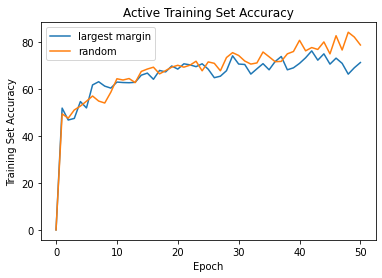

In [20]:
new_active_train_err_list = [0]
new_active_train_err_list.extend(active_train_err_list)
plt.plot(new_active_train_err_list)

new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)

plt.legend(['largest margin', 'random'])
plt.title("Active Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("x.png")
plt.show()

pickle_out = open("trained_model.pickle","wb")
pickle.dump(new_active_train_err_list, pickle_out)
pickle_out.close()

pickle_out = open("random_trained_model.pickle","wb")
pickle.dump(new_rand_train_err_list, pickle_out)
pickle_out.close()

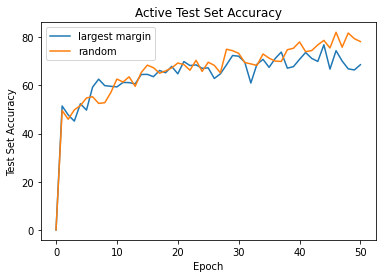

In [21]:
new_active_test_err_list = [0]
new_active_test_err_list.extend(active_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_active_test_err_list)
plt.plot(new_rand_test_err_list)
plt.legend(['largest margin', 'random'])
plt.title("Active Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("y.png")
plt.show()

pickle_out = open("model2.pickle","wb")
pickle.dump(new_active_test_err_list, pickle_out)
pickle_out.close()

pickle_out = open("model21.pickle","wb")
pickle.dump(new_rand_test_err_list, pickle_out)
pickle_out.close()

In [23]:
#after training, saving the model 
model_filename = 'model-1.model'
torch.save(random_model2.state_dict(), model_filename)

# Second Diff

In [24]:
#optimal_batch
def uncertainty_metric_max_second_difference_selection(model, trainloader):
    batch_evaluation = []
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        batch_differences = []
        for j in range(len(outputs)):
            

            vals = outputs[j].data.numpy()
            top_two = vals[np.argsort(vals)[-2:]]
            
            diff = abs(float(top_two[0] - top_two[1]))
            batch_differences.append(diff)
        batch_mean = np.mean(batch_differences)
        batch_evaluation.append(batch_mean)
    batch_evaluation = np.array(batch_evaluation)
    k = 20

    smallest = list(np.argsort(batch_evaluation)[:k])
    return smallest

In [26]:
second_loss_list = []
second_acc_list = []
second_train_err_list = []
second_test_err_list = []

for trial in range(3):
    second_model1 = Net3()
    free_params = sum(p.numel() for p in second_model1.parameters() if p.requires_grad)


    trainstep = 125
    # Loss and optimizer

    criterion = nn.NLLLoss() 
    optimizer = optim.SGD(second_model1.parameters(), lr=0.005, momentum=0.9, weight_decay=8e-4) 

    # Training the model

    total_step = len(trainloader)
    print(total_step)
    trial_second_loss_list = []
    trial_second_acc_list = []

    trial_second_train_err_list = []
    trial_second_test_err_list = []

    num_epochs = 50

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        total = 0
        correct = 0
        randomly_selected = uncertainty_metric_max_second_difference_selection(second_model1, trainloader)
        for i, (images, labels) in enumerate(trainloader):
            if i not in randomly_selected:
                continue

            images = Variable(images)
            labels = Variable(labels)
            #forward pass
 
            outputs = second_model1(images)

            loss = criterion(outputs, labels)
            trial_second_loss_list.append(loss.item())

            # Backpropagating 
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             #accuracy
            total = labels.size(0) + total
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() + correct
            trial_second_acc_list.append((correct / total)*150)


            if True:
                w = torch.nn.utils.parameters_to_vector(second_model1.parameters())
                #print(w)
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 150))
        trial_second_train_err_list.append(compute_train_acc(second_model1, trainloader))
        trial_second_test_err_list.append(compute_test_acc(second_model1, testloader))
        if (total == correct):
            break 

    second_loss_list.append(trial_second_loss_list)
    second_acc_list.append(trial_second_acc_list)
    second_train_err_list.append(trial_second_train_err_list)
    second_test_err_list.append(trial_second_test_err_list)
            
print('Finished Training') 

second_loss_list = np.array(second_loss_list)
second_acc_list = np.array(second_acc_list)
second_train_err_list= np.array(second_train_err_list)
second_test_err_list=np.array(second_test_err_list)

second_loss_list = np.mean(second_loss_list, axis=0)
second_acc_list = np.mean(second_acc_list, axis=0)
second_train_err_list= np.mean(second_train_err_list, axis=0)
second_test_err_list=np.mean(second_test_err_list, axis=0)







157
epoch:  0
Epoch [1/50], Step [6/157], Loss: 4.4127, Accuracy: 9.38%
Epoch [1/50], Step [10/157], Loss: 4.3971, Accuracy: 9.38%
Epoch [1/50], Step [16/157], Loss: 4.3561, Accuracy: 12.50%
Epoch [1/50], Step [21/157], Loss: 4.2041, Accuracy: 14.65%
Epoch [1/50], Step [25/157], Loss: 4.2783, Accuracy: 14.53%
Epoch [1/50], Step [29/157], Loss: 4.2864, Accuracy: 15.62%
Epoch [1/50], Step [33/157], Loss: 4.1336, Accuracy: 17.41%
Epoch [1/50], Step [49/157], Loss: 4.1944, Accuracy: 17.87%
Epoch [1/50], Step [50/157], Loss: 4.1065, Accuracy: 18.75%
Epoch [1/50], Step [60/157], Loss: 4.1458, Accuracy: 19.92%
Epoch [1/50], Step [64/157], Loss: 4.0818, Accuracy: 21.31%
Epoch [1/50], Step [77/157], Loss: 4.0774, Accuracy: 23.44%
Epoch [1/50], Step [85/157], Loss: 4.0683, Accuracy: 24.52%
Epoch [1/50], Step [90/157], Loss: 4.1221, Accuracy: 24.44%
Epoch [1/50], Step [92/157], Loss: 3.9921, Accuracy: 24.69%
Epoch [1/50], Step [106/157], Loss: 4.0279, Accuracy: 25.78%
Epoch [1/50], Step [115/157]

Epoch [7/50], Step [96/157], Loss: 3.9252, Accuracy: 71.78%
Epoch [7/50], Step [131/157], Loss: 3.8050, Accuracy: 72.38%
Epoch [7/50], Step [135/157], Loss: 3.8879, Accuracy: 72.40%
Epoch [7/50], Step [146/157], Loss: 3.8267, Accuracy: 72.16%
Epoch [7/50], Step [153/157], Loss: 3.8663, Accuracy: 72.66%
epoch:  7
Epoch [8/50], Step [2/157], Loss: 3.9422, Accuracy: 75.00%
Epoch [8/50], Step [18/157], Loss: 3.9077, Accuracy: 73.83%
Epoch [8/50], Step [19/157], Loss: 3.9824, Accuracy: 75.00%
Epoch [8/50], Step [22/157], Loss: 3.8342, Accuracy: 75.00%
Epoch [8/50], Step [35/157], Loss: 3.8938, Accuracy: 73.59%
Epoch [8/50], Step [46/157], Loss: 3.8711, Accuracy: 73.44%
Epoch [8/50], Step [47/157], Loss: 3.8264, Accuracy: 71.32%
Epoch [8/50], Step [61/157], Loss: 3.7735, Accuracy: 72.66%
Epoch [8/50], Step [62/157], Loss: 3.8502, Accuracy: 70.83%
Epoch [8/50], Step [64/157], Loss: 3.7679, Accuracy: 73.12%
Epoch [8/50], Step [72/157], Loss: 3.7397, Accuracy: 74.36%
Epoch [8/50], Step [74/157]

Epoch [14/50], Step [82/157], Loss: 3.8255, Accuracy: 70.10%
Epoch [14/50], Step [84/157], Loss: 3.7492, Accuracy: 68.16%
Epoch [14/50], Step [87/157], Loss: 3.8779, Accuracy: 66.53%
Epoch [14/50], Step [89/157], Loss: 3.8044, Accuracy: 66.46%
Epoch [14/50], Step [95/157], Loss: 3.9375, Accuracy: 65.47%
Epoch [14/50], Step [99/157], Loss: 3.7845, Accuracy: 65.77%
Epoch [14/50], Step [113/157], Loss: 3.9064, Accuracy: 65.49%
Epoch [14/50], Step [134/157], Loss: 3.8524, Accuracy: 64.71%
Epoch [14/50], Step [136/157], Loss: 3.8872, Accuracy: 64.27%
Epoch [14/50], Step [151/157], Loss: 3.8571, Accuracy: 64.80%
epoch:  14
Epoch [15/50], Step [3/157], Loss: 3.8360, Accuracy: 77.34%
Epoch [15/50], Step [6/157], Loss: 3.8505, Accuracy: 73.83%
Epoch [15/50], Step [11/157], Loss: 3.8211, Accuracy: 70.31%
Epoch [15/50], Step [20/157], Loss: 3.8618, Accuracy: 66.80%
Epoch [15/50], Step [32/157], Loss: 3.8720, Accuracy: 69.84%
Epoch [15/50], Step [37/157], Loss: 3.7811, Accuracy: 72.27%
Epoch [15/5

Epoch [21/50], Step [34/157], Loss: 3.7069, Accuracy: 67.38%
Epoch [21/50], Step [35/157], Loss: 3.6455, Accuracy: 67.50%
Epoch [21/50], Step [36/157], Loss: 3.9625, Accuracy: 65.62%
Epoch [21/50], Step [53/157], Loss: 3.6321, Accuracy: 66.63%
Epoch [21/50], Step [65/157], Loss: 3.8565, Accuracy: 65.33%
Epoch [21/50], Step [79/157], Loss: 3.7887, Accuracy: 65.62%
Epoch [21/50], Step [80/157], Loss: 3.7467, Accuracy: 66.56%
Epoch [21/50], Step [81/157], Loss: 3.7554, Accuracy: 67.33%
Epoch [21/50], Step [87/157], Loss: 3.7059, Accuracy: 67.38%
Epoch [21/50], Step [88/157], Loss: 3.8045, Accuracy: 66.71%
Epoch [21/50], Step [104/157], Loss: 3.6967, Accuracy: 66.96%
Epoch [21/50], Step [110/157], Loss: 3.8205, Accuracy: 66.56%
Epoch [21/50], Step [113/157], Loss: 3.8198, Accuracy: 66.50%
Epoch [21/50], Step [120/157], Loss: 3.7128, Accuracy: 67.56%
Epoch [21/50], Step [121/157], Loss: 3.7693, Accuracy: 67.32%
Epoch [21/50], Step [140/157], Loss: 3.7533, Accuracy: 68.09%
Epoch [21/50], Ste

Epoch [27/50], Step [114/157], Loss: 3.6832, Accuracy: 68.52%
Epoch [27/50], Step [120/157], Loss: 3.7724, Accuracy: 67.45%
Epoch [27/50], Step [122/157], Loss: 3.7164, Accuracy: 67.48%
Epoch [27/50], Step [123/157], Loss: 3.7854, Accuracy: 67.27%
epoch:  27
Epoch [28/50], Step [4/157], Loss: 3.7484, Accuracy: 67.97%
Epoch [28/50], Step [21/157], Loss: 3.6726, Accuracy: 70.31%
Epoch [28/50], Step [34/157], Loss: 3.7755, Accuracy: 68.75%
Epoch [28/50], Step [40/157], Loss: 3.5864, Accuracy: 70.31%
Epoch [28/50], Step [53/157], Loss: 3.7120, Accuracy: 68.91%
Epoch [28/50], Step [55/157], Loss: 3.7150, Accuracy: 68.36%
Epoch [28/50], Step [56/157], Loss: 3.6683, Accuracy: 69.64%
Epoch [28/50], Step [57/157], Loss: 3.6533, Accuracy: 70.31%
Epoch [28/50], Step [66/157], Loss: 3.6237, Accuracy: 71.09%
Epoch [28/50], Step [73/157], Loss: 3.9094, Accuracy: 70.31%
Epoch [28/50], Step [84/157], Loss: 3.8049, Accuracy: 69.67%
Epoch [28/50], Step [86/157], Loss: 3.6700, Accuracy: 69.53%
Epoch [28/

Epoch [34/50], Step [78/157], Loss: 3.7776, Accuracy: 73.83%
Epoch [34/50], Step [88/157], Loss: 3.6365, Accuracy: 72.87%
Epoch [34/50], Step [95/157], Loss: 3.7638, Accuracy: 71.48%
Epoch [34/50], Step [105/157], Loss: 3.7293, Accuracy: 71.39%
Epoch [34/50], Step [110/157], Loss: 3.8151, Accuracy: 71.15%
Epoch [34/50], Step [112/157], Loss: 3.6474, Accuracy: 70.94%
Epoch [34/50], Step [113/157], Loss: 3.6906, Accuracy: 70.75%
Epoch [34/50], Step [115/157], Loss: 3.6287, Accuracy: 70.73%
Epoch [34/50], Step [120/157], Loss: 3.7791, Accuracy: 70.83%
Epoch [34/50], Step [122/157], Loss: 3.7044, Accuracy: 71.30%
Epoch [34/50], Step [156/157], Loss: 3.7190, Accuracy: 71.60%
epoch:  34
Epoch [35/50], Step [10/157], Loss: 3.6347, Accuracy: 65.62%
Epoch [35/50], Step [21/157], Loss: 3.6596, Accuracy: 65.62%
Epoch [35/50], Step [34/157], Loss: 3.8874, Accuracy: 67.19%
Epoch [35/50], Step [37/157], Loss: 3.5901, Accuracy: 70.90%
Epoch [35/50], Step [43/157], Loss: 3.6534, Accuracy: 71.25%
Epoch

Epoch [41/50], Step [9/157], Loss: 3.6435, Accuracy: 73.44%
Epoch [41/50], Step [14/157], Loss: 3.6514, Accuracy: 75.00%
Epoch [41/50], Step [20/157], Loss: 3.5716, Accuracy: 74.53%
Epoch [41/50], Step [21/157], Loss: 3.6053, Accuracy: 75.78%
Epoch [41/50], Step [22/157], Loss: 3.6870, Accuracy: 75.00%
Epoch [41/50], Step [35/157], Loss: 3.6242, Accuracy: 75.00%
Epoch [41/50], Step [40/157], Loss: 3.5635, Accuracy: 74.22%
Epoch [41/50], Step [42/157], Loss: 3.5547, Accuracy: 74.77%
Epoch [41/50], Step [53/157], Loss: 3.6601, Accuracy: 75.64%
Epoch [41/50], Step [59/157], Loss: 3.8725, Accuracy: 75.20%
Epoch [41/50], Step [66/157], Loss: 3.7189, Accuracy: 74.46%
Epoch [41/50], Step [69/157], Loss: 3.8544, Accuracy: 74.16%
Epoch [41/50], Step [78/157], Loss: 3.6214, Accuracy: 73.91%
Epoch [41/50], Step [96/157], Loss: 3.6006, Accuracy: 74.56%
Epoch [41/50], Step [102/157], Loss: 3.7407, Accuracy: 74.45%
Epoch [41/50], Step [115/157], Loss: 3.6406, Accuracy: 74.74%
Epoch [41/50], Step [12

Epoch [47/50], Step [129/157], Loss: 3.7772, Accuracy: 79.39%
Epoch [47/50], Step [133/157], Loss: 3.6634, Accuracy: 79.14%
Epoch [47/50], Step [145/157], Loss: 3.7064, Accuracy: 79.56%
Epoch [47/50], Step [147/157], Loss: 3.6398, Accuracy: 79.44%
Epoch [47/50], Step [148/157], Loss: 3.6611, Accuracy: 80.39%
epoch:  47
Epoch [48/50], Step [1/157], Loss: 3.5966, Accuracy: 75.00%
Epoch [48/50], Step [2/157], Loss: 3.5442, Accuracy: 86.72%
Epoch [48/50], Step [8/157], Loss: 3.7354, Accuracy: 85.94%
Epoch [48/50], Step [12/157], Loss: 3.6157, Accuracy: 84.38%
Epoch [48/50], Step [17/157], Loss: 3.6619, Accuracy: 84.38%
Epoch [48/50], Step [20/157], Loss: 3.5974, Accuracy: 81.64%
Epoch [48/50], Step [25/157], Loss: 3.6219, Accuracy: 83.71%
Epoch [48/50], Step [28/157], Loss: 3.7815, Accuracy: 82.03%
Epoch [48/50], Step [38/157], Loss: 3.5365, Accuracy: 82.29%
Epoch [48/50], Step [76/157], Loss: 3.5776, Accuracy: 84.14%
Epoch [48/50], Step [86/157], Loss: 3.5555, Accuracy: 85.23%
Epoch [48/5

Epoch [4/50], Step [100/157], Loss: 3.7813, Accuracy: 43.12%
Epoch [4/50], Step [105/157], Loss: 3.9006, Accuracy: 42.83%
Epoch [4/50], Step [113/157], Loss: 3.7890, Accuracy: 42.97%
Epoch [4/50], Step [125/157], Loss: 3.9487, Accuracy: 43.63%
Epoch [4/50], Step [129/157], Loss: 3.9027, Accuracy: 44.53%
Epoch [4/50], Step [133/157], Loss: 3.9258, Accuracy: 43.91%
Epoch [4/50], Step [146/157], Loss: 3.9095, Accuracy: 43.95%
Epoch [4/50], Step [148/157], Loss: 3.9775, Accuracy: 43.70%
Epoch [4/50], Step [149/157], Loss: 3.8710, Accuracy: 43.88%
Epoch [4/50], Step [153/157], Loss: 4.0675, Accuracy: 43.42%
Epoch [4/50], Step [154/157], Loss: 3.9775, Accuracy: 42.77%
epoch:  4
Epoch [5/50], Step [6/157], Loss: 4.0052, Accuracy: 39.84%
Epoch [5/50], Step [16/157], Loss: 3.8741, Accuracy: 39.84%
Epoch [5/50], Step [55/157], Loss: 3.8831, Accuracy: 43.75%
Epoch [5/50], Step [78/157], Loss: 3.9384, Accuracy: 43.36%
Epoch [5/50], Step [80/157], Loss: 3.8760, Accuracy: 42.66%
Epoch [5/50], Step [

Epoch [11/50], Step [31/157], Loss: 3.8528, Accuracy: 43.12%
Epoch [11/50], Step [46/157], Loss: 3.9072, Accuracy: 44.53%
Epoch [11/50], Step [51/157], Loss: 3.6887, Accuracy: 47.54%
Epoch [11/50], Step [57/157], Loss: 3.9117, Accuracy: 46.88%
Epoch [11/50], Step [60/157], Loss: 3.8614, Accuracy: 45.83%
Epoch [11/50], Step [70/157], Loss: 3.9840, Accuracy: 45.94%
Epoch [11/50], Step [77/157], Loss: 3.9414, Accuracy: 44.11%
Epoch [11/50], Step [82/157], Loss: 3.8733, Accuracy: 44.53%
Epoch [11/50], Step [119/157], Loss: 3.8311, Accuracy: 44.17%
Epoch [11/50], Step [126/157], Loss: 3.8751, Accuracy: 44.20%
Epoch [11/50], Step [141/157], Loss: 3.8586, Accuracy: 43.91%
Epoch [11/50], Step [145/157], Loss: 3.9156, Accuracy: 43.95%
Epoch [11/50], Step [148/157], Loss: 3.7992, Accuracy: 44.26%
Epoch [11/50], Step [149/157], Loss: 3.8312, Accuracy: 44.92%
Epoch [11/50], Step [154/157], Loss: 3.9107, Accuracy: 45.15%
Epoch [11/50], Step [157/157], Loss: 2.4522, Accuracy: 45.41%
epoch:  11
Epoch

Epoch [17/50], Step [138/157], Loss: 3.8631, Accuracy: 57.81%
Epoch [17/50], Step [149/157], Loss: 3.8304, Accuracy: 57.98%
Epoch [17/50], Step [150/157], Loss: 3.6651, Accuracy: 57.19%
epoch:  17
Epoch [18/50], Step [11/157], Loss: 3.8041, Accuracy: 65.62%
Epoch [18/50], Step [24/157], Loss: 3.8429, Accuracy: 59.77%
Epoch [18/50], Step [47/157], Loss: 3.8361, Accuracy: 53.91%
Epoch [18/50], Step [59/157], Loss: 3.7996, Accuracy: 53.32%
Epoch [18/50], Step [65/157], Loss: 3.7723, Accuracy: 52.50%
Epoch [18/50], Step [73/157], Loss: 3.9062, Accuracy: 52.34%
Epoch [18/50], Step [78/157], Loss: 3.8011, Accuracy: 51.56%
Epoch [18/50], Step [80/157], Loss: 3.8054, Accuracy: 51.27%
Epoch [18/50], Step [82/157], Loss: 3.8099, Accuracy: 52.60%
Epoch [18/50], Step [85/157], Loss: 3.8653, Accuracy: 52.97%
Epoch [18/50], Step [88/157], Loss: 3.7726, Accuracy: 52.63%
Epoch [18/50], Step [98/157], Loss: 3.9773, Accuracy: 51.56%
Epoch [18/50], Step [103/157], Loss: 3.7745, Accuracy: 51.20%
Epoch [18

Epoch [24/50], Step [98/157], Loss: 3.7352, Accuracy: 54.55%
Epoch [24/50], Step [113/157], Loss: 3.7837, Accuracy: 54.69%
Epoch [24/50], Step [116/157], Loss: 3.7745, Accuracy: 55.17%
Epoch [24/50], Step [119/157], Loss: 3.7585, Accuracy: 56.25%
Epoch [24/50], Step [121/157], Loss: 3.9226, Accuracy: 55.62%
Epoch [24/50], Step [130/157], Loss: 3.8411, Accuracy: 55.52%
Epoch [24/50], Step [141/157], Loss: 3.8197, Accuracy: 55.42%
Epoch [24/50], Step [150/157], Loss: 3.7944, Accuracy: 55.60%
Epoch [24/50], Step [154/157], Loss: 3.8311, Accuracy: 55.02%
Epoch [24/50], Step [157/157], Loss: 2.3021, Accuracy: 55.15%
epoch:  24
Epoch [25/50], Step [4/157], Loss: 3.8169, Accuracy: 63.28%
Epoch [25/50], Step [11/157], Loss: 3.9455, Accuracy: 55.08%
Epoch [25/50], Step [14/157], Loss: 3.9054, Accuracy: 61.72%
Epoch [25/50], Step [22/157], Loss: 3.7312, Accuracy: 63.28%
Epoch [25/50], Step [23/157], Loss: 3.7161, Accuracy: 62.34%
Epoch [25/50], Step [35/157], Loss: 3.7547, Accuracy: 61.33%
Epoch

Epoch [31/50], Step [22/157], Loss: 3.7140, Accuracy: 71.48%
Epoch [31/50], Step [29/157], Loss: 3.8107, Accuracy: 70.31%
Epoch [31/50], Step [31/157], Loss: 3.6885, Accuracy: 66.80%
Epoch [31/50], Step [37/157], Loss: 3.8116, Accuracy: 65.62%
Epoch [31/50], Step [51/157], Loss: 3.7788, Accuracy: 64.75%
Epoch [31/50], Step [54/157], Loss: 3.8528, Accuracy: 63.28%
Epoch [31/50], Step [68/157], Loss: 3.8035, Accuracy: 62.11%
Epoch [31/50], Step [70/157], Loss: 3.6899, Accuracy: 61.15%
Epoch [31/50], Step [83/157], Loss: 3.8128, Accuracy: 61.72%
Epoch [31/50], Step [91/157], Loss: 3.7006, Accuracy: 61.12%
Epoch [31/50], Step [94/157], Loss: 3.6067, Accuracy: 60.44%
Epoch [31/50], Step [113/157], Loss: 4.0244, Accuracy: 59.84%
Epoch [31/50], Step [132/157], Loss: 3.7391, Accuracy: 59.33%
Epoch [31/50], Step [136/157], Loss: 3.7315, Accuracy: 59.97%
Epoch [31/50], Step [150/157], Loss: 3.7358, Accuracy: 59.11%
Epoch [31/50], Step [154/157], Loss: 3.6740, Accuracy: 58.72%
Epoch [31/50], Step

Epoch [37/50], Step [135/157], Loss: 3.7123, Accuracy: 64.11%
Epoch [37/50], Step [139/157], Loss: 3.6833, Accuracy: 63.80%
Epoch [37/50], Step [143/157], Loss: 3.6886, Accuracy: 63.90%
Epoch [37/50], Step [157/157], Loss: 2.3321, Accuracy: 64.04%
epoch:  37
Epoch [38/50], Step [6/157], Loss: 3.7370, Accuracy: 86.72%
Epoch [38/50], Step [14/157], Loss: 3.7095, Accuracy: 73.83%
Epoch [38/50], Step [15/157], Loss: 3.6154, Accuracy: 66.41%
Epoch [38/50], Step [24/157], Loss: 3.6636, Accuracy: 65.62%
Epoch [38/50], Step [31/157], Loss: 3.7556, Accuracy: 63.75%
Epoch [38/50], Step [32/157], Loss: 3.7618, Accuracy: 60.94%
Epoch [38/50], Step [33/157], Loss: 3.9224, Accuracy: 61.27%
Epoch [38/50], Step [35/157], Loss: 3.6730, Accuracy: 62.11%
Epoch [38/50], Step [62/157], Loss: 3.7159, Accuracy: 61.20%
Epoch [38/50], Step [63/157], Loss: 3.7909, Accuracy: 61.17%
Epoch [38/50], Step [73/157], Loss: 3.7407, Accuracy: 62.22%
Epoch [38/50], Step [75/157], Loss: 3.6774, Accuracy: 62.70%
Epoch [38/

Epoch [44/50], Step [45/157], Loss: 3.6179, Accuracy: 64.92%
Epoch [44/50], Step [46/157], Loss: 3.6687, Accuracy: 64.56%
Epoch [44/50], Step [55/157], Loss: 3.6041, Accuracy: 65.43%
Epoch [44/50], Step [78/157], Loss: 3.6409, Accuracy: 65.62%
Epoch [44/50], Step [93/157], Loss: 3.7208, Accuracy: 64.79%
Epoch [44/50], Step [108/157], Loss: 3.5709, Accuracy: 65.16%
Epoch [44/50], Step [118/157], Loss: 3.6820, Accuracy: 64.89%
Epoch [44/50], Step [123/157], Loss: 3.6283, Accuracy: 64.94%
Epoch [44/50], Step [130/157], Loss: 3.6621, Accuracy: 64.71%
Epoch [44/50], Step [143/157], Loss: 3.7256, Accuracy: 64.39%
Epoch [44/50], Step [148/157], Loss: 3.6086, Accuracy: 65.27%
epoch:  44
Epoch [45/50], Step [2/157], Loss: 3.7197, Accuracy: 79.69%
Epoch [45/50], Step [22/157], Loss: 3.5226, Accuracy: 82.03%
Epoch [45/50], Step [29/157], Loss: 3.6326, Accuracy: 76.56%
Epoch [45/50], Step [34/157], Loss: 3.5717, Accuracy: 75.59%
Epoch [45/50], Step [38/157], Loss: 3.5944, Accuracy: 77.81%
Epoch [4

Epoch [1/50], Step [10/157], Loss: 4.2761, Accuracy: 18.75%
Epoch [1/50], Step [18/157], Loss: 4.1698, Accuracy: 21.68%
Epoch [1/50], Step [20/157], Loss: 4.2074, Accuracy: 22.50%
Epoch [1/50], Step [22/157], Loss: 4.0870, Accuracy: 24.61%
Epoch [1/50], Step [23/157], Loss: 4.2865, Accuracy: 25.45%
Epoch [1/50], Step [29/157], Loss: 4.1558, Accuracy: 26.37%
Epoch [1/50], Step [31/157], Loss: 4.0709, Accuracy: 26.56%
Epoch [1/50], Step [36/157], Loss: 4.1941, Accuracy: 27.19%
Epoch [1/50], Step [51/157], Loss: 4.0904, Accuracy: 27.49%
Epoch [1/50], Step [54/157], Loss: 4.0693, Accuracy: 27.54%
Epoch [1/50], Step [82/157], Loss: 4.1062, Accuracy: 27.94%
Epoch [1/50], Step [125/157], Loss: 4.0328, Accuracy: 28.46%
Epoch [1/50], Step [128/157], Loss: 4.1080, Accuracy: 28.59%
Epoch [1/50], Step [129/157], Loss: 4.0634, Accuracy: 29.59%
Epoch [1/50], Step [141/157], Loss: 4.0110, Accuracy: 29.64%
Epoch [1/50], Step [147/157], Loss: 4.0945, Accuracy: 29.95%
Epoch [1/50], Step [148/157], Loss:

Epoch [7/50], Step [138/157], Loss: 3.9042, Accuracy: 48.44%
Epoch [7/50], Step [142/157], Loss: 3.9145, Accuracy: 48.60%
Epoch [7/50], Step [146/157], Loss: 3.7918, Accuracy: 49.69%
epoch:  7
Epoch [8/50], Step [6/157], Loss: 3.8395, Accuracy: 56.25%
Epoch [8/50], Step [34/157], Loss: 3.8238, Accuracy: 58.59%
Epoch [8/50], Step [37/157], Loss: 3.8822, Accuracy: 53.12%
Epoch [8/50], Step [44/157], Loss: 3.9570, Accuracy: 53.32%
Epoch [8/50], Step [47/157], Loss: 3.9118, Accuracy: 52.50%
Epoch [8/50], Step [51/157], Loss: 3.9711, Accuracy: 51.56%
Epoch [8/50], Step [63/157], Loss: 3.9870, Accuracy: 49.89%
Epoch [8/50], Step [64/157], Loss: 4.0311, Accuracy: 50.10%
Epoch [8/50], Step [65/157], Loss: 3.8809, Accuracy: 51.82%
Epoch [8/50], Step [68/157], Loss: 3.9486, Accuracy: 52.27%
Epoch [8/50], Step [84/157], Loss: 3.9784, Accuracy: 52.63%
Epoch [8/50], Step [87/157], Loss: 3.9452, Accuracy: 51.95%
Epoch [8/50], Step [104/157], Loss: 3.8821, Accuracy: 53.19%
Epoch [8/50], Step [105/157

Epoch [14/50], Step [97/157], Loss: 3.8094, Accuracy: 52.34%
Epoch [14/50], Step [110/157], Loss: 3.7545, Accuracy: 53.00%
Epoch [14/50], Step [111/157], Loss: 3.9467, Accuracy: 53.24%
Epoch [14/50], Step [112/157], Loss: 3.8253, Accuracy: 53.28%
Epoch [14/50], Step [116/157], Loss: 3.8491, Accuracy: 53.91%
Epoch [14/50], Step [123/157], Loss: 3.9563, Accuracy: 54.04%
Epoch [14/50], Step [126/157], Loss: 3.8487, Accuracy: 54.82%
Epoch [14/50], Step [130/157], Loss: 3.9812, Accuracy: 55.26%
Epoch [14/50], Step [147/157], Loss: 3.9165, Accuracy: 55.78%
epoch:  14
Epoch [15/50], Step [1/157], Loss: 3.9929, Accuracy: 63.28%
Epoch [15/50], Step [17/157], Loss: 3.8776, Accuracy: 66.80%
Epoch [15/50], Step [36/157], Loss: 3.8923, Accuracy: 62.50%
Epoch [15/50], Step [39/157], Loss: 3.8226, Accuracy: 62.11%
Epoch [15/50], Step [47/157], Loss: 3.8344, Accuracy: 61.41%
Epoch [15/50], Step [55/157], Loss: 3.8610, Accuracy: 61.72%
Epoch [15/50], Step [57/157], Loss: 3.7534, Accuracy: 61.27%
Epoch 

Epoch [21/50], Step [58/157], Loss: 3.8561, Accuracy: 63.67%
Epoch [21/50], Step [60/157], Loss: 3.8795, Accuracy: 64.62%
Epoch [21/50], Step [61/157], Loss: 3.7266, Accuracy: 65.04%
Epoch [21/50], Step [64/157], Loss: 3.6948, Accuracy: 63.54%
Epoch [21/50], Step [68/157], Loss: 3.9768, Accuracy: 62.58%
Epoch [21/50], Step [69/157], Loss: 3.9321, Accuracy: 61.79%
Epoch [21/50], Step [70/157], Loss: 3.8852, Accuracy: 61.13%
Epoch [21/50], Step [91/157], Loss: 3.7937, Accuracy: 61.66%
Epoch [21/50], Step [106/157], Loss: 3.8246, Accuracy: 62.28%
Epoch [21/50], Step [109/157], Loss: 3.7374, Accuracy: 61.72%
Epoch [21/50], Step [115/157], Loss: 3.6988, Accuracy: 63.13%
Epoch [21/50], Step [118/157], Loss: 3.8003, Accuracy: 62.73%
Epoch [21/50], Step [121/157], Loss: 3.8062, Accuracy: 63.28%
Epoch [21/50], Step [125/157], Loss: 3.7546, Accuracy: 64.27%
Epoch [21/50], Step [131/157], Loss: 3.8582, Accuracy: 64.45%
epoch:  21
Epoch [22/50], Step [2/157], Loss: 4.0187, Accuracy: 58.59%
Epoch [

Epoch [27/50], Step [152/157], Loss: 3.7709, Accuracy: 65.62%
Epoch [27/50], Step [156/157], Loss: 3.7632, Accuracy: 64.80%
epoch:  27
Epoch [28/50], Step [3/157], Loss: 3.8278, Accuracy: 39.84%
Epoch [28/50], Step [5/157], Loss: 3.8480, Accuracy: 46.88%
Epoch [28/50], Step [24/157], Loss: 3.9066, Accuracy: 53.12%
Epoch [28/50], Step [26/157], Loss: 3.8428, Accuracy: 50.39%
Epoch [28/50], Step [32/157], Loss: 3.8078, Accuracy: 53.44%
Epoch [28/50], Step [39/157], Loss: 3.6868, Accuracy: 55.47%
Epoch [28/50], Step [57/157], Loss: 3.7411, Accuracy: 56.92%
Epoch [28/50], Step [58/157], Loss: 3.9558, Accuracy: 58.30%
Epoch [28/50], Step [62/157], Loss: 3.8882, Accuracy: 59.90%
Epoch [28/50], Step [72/157], Loss: 3.7328, Accuracy: 60.23%
Epoch [28/50], Step [77/157], Loss: 3.7275, Accuracy: 62.00%
Epoch [28/50], Step [92/157], Loss: 3.7330, Accuracy: 62.50%
Epoch [28/50], Step [94/157], Loss: 3.7169, Accuracy: 63.10%
Epoch [28/50], Step [96/157], Loss: 3.6959, Accuracy: 64.45%
Epoch [28/50]

Epoch [34/50], Step [99/157], Loss: 3.6690, Accuracy: 74.02%
Epoch [34/50], Step [103/157], Loss: 3.7389, Accuracy: 74.10%
Epoch [34/50], Step [104/157], Loss: 3.7444, Accuracy: 73.16%
Epoch [34/50], Step [114/157], Loss: 3.7253, Accuracy: 71.88%
Epoch [34/50], Step [117/157], Loss: 3.7846, Accuracy: 71.04%
Epoch [34/50], Step [136/157], Loss: 3.8313, Accuracy: 70.31%
Epoch [34/50], Step [137/157], Loss: 3.8432, Accuracy: 69.40%
Epoch [34/50], Step [146/157], Loss: 3.7206, Accuracy: 68.83%
Epoch [34/50], Step [156/157], Loss: 3.8029, Accuracy: 69.38%
epoch:  34
Epoch [35/50], Step [19/157], Loss: 3.8104, Accuracy: 77.34%
Epoch [35/50], Step [24/157], Loss: 3.7468, Accuracy: 76.17%
Epoch [35/50], Step [25/157], Loss: 3.8427, Accuracy: 71.09%
Epoch [35/50], Step [26/157], Loss: 3.7550, Accuracy: 67.97%
Epoch [35/50], Step [29/157], Loss: 3.7162, Accuracy: 65.62%
Epoch [35/50], Step [36/157], Loss: 3.6740, Accuracy: 67.97%
Epoch [35/50], Step [42/157], Loss: 3.7373, Accuracy: 67.30%
Epoch

Epoch [41/50], Step [34/157], Loss: 3.8902, Accuracy: 70.78%
Epoch [41/50], Step [40/157], Loss: 3.6541, Accuracy: 72.27%
Epoch [41/50], Step [46/157], Loss: 3.7673, Accuracy: 72.99%
Epoch [41/50], Step [51/157], Loss: 3.7837, Accuracy: 72.66%
Epoch [41/50], Step [63/157], Loss: 3.7923, Accuracy: 73.96%
Epoch [41/50], Step [70/157], Loss: 3.7723, Accuracy: 73.36%
Epoch [41/50], Step [71/157], Loss: 3.9372, Accuracy: 73.08%
Epoch [41/50], Step [79/157], Loss: 3.6388, Accuracy: 72.85%
Epoch [41/50], Step [88/157], Loss: 3.8180, Accuracy: 73.02%
Epoch [41/50], Step [90/157], Loss: 3.8686, Accuracy: 72.82%
Epoch [41/50], Step [106/157], Loss: 3.8962, Accuracy: 72.50%
Epoch [41/50], Step [108/157], Loss: 3.7216, Accuracy: 72.22%
Epoch [41/50], Step [119/157], Loss: 3.6258, Accuracy: 71.69%
Epoch [41/50], Step [128/157], Loss: 3.6057, Accuracy: 72.66%
Epoch [41/50], Step [132/157], Loss: 3.7864, Accuracy: 72.04%
Epoch [41/50], Step [147/157], Loss: 3.6739, Accuracy: 71.84%
epoch:  41
Epoch [

Epoch [47/50], Step [132/157], Loss: 3.6066, Accuracy: 74.61%
Epoch [47/50], Step [141/157], Loss: 3.7766, Accuracy: 74.51%
Epoch [47/50], Step [151/157], Loss: 3.6252, Accuracy: 74.88%
epoch:  47
Epoch [48/50], Step [4/157], Loss: 3.6416, Accuracy: 67.97%
Epoch [48/50], Step [12/157], Loss: 3.8481, Accuracy: 67.97%
Epoch [48/50], Step [31/157], Loss: 3.9387, Accuracy: 66.41%
Epoch [48/50], Step [37/157], Loss: 3.5865, Accuracy: 67.38%
Epoch [48/50], Step [41/157], Loss: 3.7088, Accuracy: 70.78%
Epoch [48/50], Step [48/157], Loss: 3.7009, Accuracy: 73.05%
Epoch [48/50], Step [54/157], Loss: 3.6067, Accuracy: 73.66%
Epoch [48/50], Step [60/157], Loss: 3.6729, Accuracy: 74.71%
Epoch [48/50], Step [79/157], Loss: 3.8010, Accuracy: 74.22%
Epoch [48/50], Step [80/157], Loss: 3.6174, Accuracy: 74.06%
Epoch [48/50], Step [83/157], Loss: 3.7855, Accuracy: 73.51%
Epoch [48/50], Step [94/157], Loss: 3.6619, Accuracy: 72.85%
Epoch [48/50], Step [100/157], Loss: 3.6794, Accuracy: 71.94%
Epoch [48/

In [27]:
#after training, saving model 
model_filename = 'model-2.model'
torch.save(second_model1.state_dict(), model_filename)

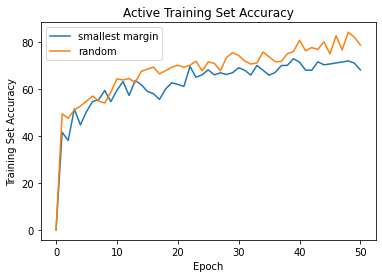

In [28]:
new_second_train_err_list = [0]
new_second_train_err_list.extend(second_train_err_list)
plt.plot(new_second_train_err_list)

new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)

plt.legend(['smallest margin', 'random'])
plt.title("Active Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("b.png")
plt.show()

pickle_out = open("smallest_margin.pickle","wb")
pickle.dump(new_second_train_err_list, pickle_out)
pickle_out.close()

pickle_out = open("random_training.pickle","wb")
pickle.dump(new_rand_train_err_list, pickle_out)
pickle_out.close()

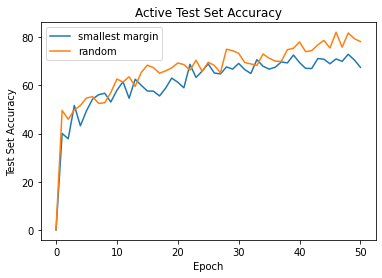

In [29]:
new_second_test_err_list = [0]
new_second_test_err_list.extend(second_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_second_test_err_list)
plt.plot(new_rand_test_err_list)
plt.legend(['smallest margin', 'random'])
plt.title("Active Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("c.png")
plt.show()

pickle_out = open("smallest_margin.pickle","wb")
pickle.dump(new_second_test_err_list, pickle_out)
pickle_out.close()

pickle_out = open("random_testing.pickle","wb")
pickle.dump(new_rand_test_err_list, pickle_out)
pickle_out.close()

# Compare Active, Second, Random

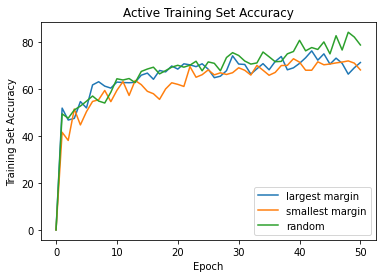

In [30]:
new_active_train_err_list = [0]
new_active_train_err_list.extend(active_train_err_list)
plt.plot(new_active_train_err_list)

new_second_train_err_list = [0]
new_second_train_err_list.extend(second_train_err_list)
plt.plot(new_second_train_err_list)
new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)
plt.legend(['largest margin', 'smallest margin', 'random'])
plt.title("Active Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("e.png")
plt.show()


pickle_out = open("largest_margin.pickle","wb")
pickle.dump(new_active_train_err_list, pickle_out)
pickle_out.close()


pickle_out = open("smallest_margin.pickle","wb")
pickle.dump(new_second_train_err_list, pickle_out)
pickle_out.close()

pickle_out = open("random_training.pickle","wb")
pickle.dump(new_rand_train_err_list, pickle_out)
pickle_out.close()

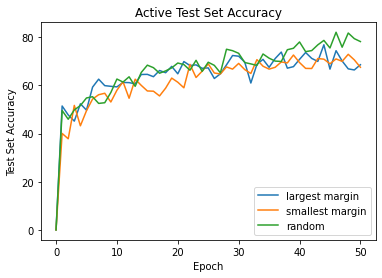

In [31]:
new_active_test_err_list = [0]
new_active_test_err_list.extend(active_test_err_list)

new_second_test_err_list = [0]
new_second_test_err_list.extend(second_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_active_test_err_list)
plt.plot(new_second_test_err_list)
plt.plot(new_rand_test_err_list)
plt.legend(['largest margin', 'smallest margin', 'random'])
plt.title("Active Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("f.png")
plt.show()

pickle_out = open("largest_margin.pickle","wb")
pickle.dump(new_active_test_err_list, pickle_out)
pickle_out.close()

pickle_out = open("smallest_margin.pickle","wb")
pickle.dump(new_second_test_err_list, pickle_out)
pickle_out.close()

pickle_out = open("random_testing.pickle","wb")
pickle.dump(new_rand_test_err_list, pickle_out)
pickle_out.close()

# Entropy Reduction

In [8]:
#optimal_batch
def uncertainty_metric_entropy_selection(model, trainloader):
    batch_evaluation = []
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        batch_differences = []
        for j in range(len(outputs)):
            total = 0
            output_probs = outputs[j].data.numpy()
            for item in output_probs:
                entropy = -1* item * np.log(item)
                total += entropy
            batch_differences.append(total)
            
        batch_mean = np.mean(batch_differences)
        batch_evaluation.append(batch_mean)
    batch_evaluation = np.array(batch_evaluation)
    k = 20
    largest = list((-batch_evaluation).argsort()[:k])

    return largest

In [9]:
entropy_loss_list = []
entropy_acc_list = []
entropy_train_err_list = []
entropy_test_err_list = []

for trial in range(3):
    entropy_model1 = Net3()
    free_params = sum(p.numel() for p in entropy_model1.parameters() if p.requires_grad)
    print(free_params)

    trainstep = 125
    # Loss and optimizer

    criterion = nn.NLLLoss() 
    optimizer = optim.SGD(entropy_model1.parameters(), lr=0.005, momentum=0.9, weight_decay=8e-4) 

    # Training the model

    total_step = len(trainloader)
    print(total_step)
    trial_entropy_loss_list = []
    trial_entropy_acc_list = []

    trial_entropy_train_err_list = []
    trial_entropy_test_err_list = []

    num_epochs = 50

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        total = 0
        correct = 0
        randomly_selected = uncertainty_metric_entropy_selection(entropy_model1, trainloader)
        for i, (images, labels) in enumerate(trainloader):
            if i not in randomly_selected:
                continue

            images = Variable(images)
            labels = Variable(labels)
            #forward pass
   
            outputs = entropy_model1(images)

            loss = criterion(outputs, labels)
            trial_entropy_loss_list.append(loss.item())

            # Backpropagating
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             #accuracy
            total = labels.size(0) + total
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() + correct
            trial_entropy_acc_list.append((correct / total)*120)


            if True:
                w = torch.nn.utils.parameters_to_vector(entropy_model1.parameters())
                #print(w)
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 120))
        trial_entropy_train_err_list.append(compute_train_acc(entropy_model1, trainloader))
        trial_entropy_test_err_list.append(compute_test_acc(entropy_model1, testloader))
        if (total == correct):
            break 

    entropy_loss_list.append(trial_entropy_loss_list)
    entropy_acc_list.append(trial_entropy_acc_list)
    entropy_train_err_list.append(trial_entropy_train_err_list)
    entropy_test_err_list.append(trial_entropy_test_err_list)
            
print('Finished Training') 

entropy_loss_list = np.array(entropy_loss_list)
entropy_acc_list = np.array(entropy_acc_list)
entropy_train_err_list= np.array(entropy_train_err_list)
entropy_test_err_list=np.array(entropy_test_err_list)

entropy_loss_list = np.mean(entropy_loss_list, axis=0)
entropy_acc_list = np.mean(entropy_acc_list, axis=0)
entropy_train_err_list= np.mean(entropy_train_err_list, axis=0)
entropy_test_err_list=np.mean(entropy_test_err_list, axis=0)






120753
157
epoch:  0


C:\Users\kavya\AppData\Local\Temp\ipykernel_7048\2235848017.py:11: RuntimeWarning: invalid value encountered in log
  entropy = -1* item * np.log(item)


Epoch [1/50], Step [1/157], Loss: 4.4026, Accuracy: 5.62%
Epoch [1/50], Step [97/157], Loss: 4.2947, Accuracy: 10.31%
Epoch [1/50], Step [98/157], Loss: 4.1376, Accuracy: 10.62%
Epoch [1/50], Step [99/157], Loss: 4.1570, Accuracy: 12.19%
Epoch [1/50], Step [100/157], Loss: 4.1386, Accuracy: 12.75%
Epoch [1/50], Step [101/157], Loss: 4.2216, Accuracy: 13.12%
Epoch [1/50], Step [102/157], Loss: 4.2807, Accuracy: 13.12%
Epoch [1/50], Step [103/157], Loss: 4.1348, Accuracy: 14.77%
Epoch [1/50], Step [104/157], Loss: 4.0635, Accuracy: 15.63%
Epoch [1/50], Step [105/157], Loss: 4.0648, Accuracy: 16.31%
Epoch [1/50], Step [106/157], Loss: 4.0207, Accuracy: 16.53%
Epoch [1/50], Step [107/157], Loss: 4.1273, Accuracy: 16.56%
Epoch [1/50], Step [108/157], Loss: 4.0628, Accuracy: 16.88%
Epoch [1/50], Step [109/157], Loss: 3.9734, Accuracy: 17.68%
Epoch [1/50], Step [110/157], Loss: 3.9699, Accuracy: 17.50%
Epoch [1/50], Step [111/157], Loss: 4.0627, Accuracy: 18.05%
Epoch [1/50], Step [112/157], 

Epoch [7/50], Step [110/157], Loss: 3.8716, Accuracy: 23.25%
Epoch [7/50], Step [111/157], Loss: 3.8390, Accuracy: 23.91%
Epoch [7/50], Step [112/157], Loss: 3.8705, Accuracy: 24.38%
Epoch [7/50], Step [113/157], Loss: 3.9318, Accuracy: 25.10%
Epoch [7/50], Step [114/157], Loss: 3.9776, Accuracy: 25.16%
Epoch [7/50], Step [115/157], Loss: 3.8530, Accuracy: 25.22%
epoch:  7
Epoch [8/50], Step [1/157], Loss: 3.8687, Accuracy: 31.88%
Epoch [8/50], Step [97/157], Loss: 3.9821, Accuracy: 28.12%
Epoch [8/50], Step [98/157], Loss: 3.9324, Accuracy: 27.50%
Epoch [8/50], Step [99/157], Loss: 3.8383, Accuracy: 29.06%
Epoch [8/50], Step [100/157], Loss: 3.9080, Accuracy: 27.75%
Epoch [8/50], Step [101/157], Loss: 3.8214, Accuracy: 27.19%
Epoch [8/50], Step [102/157], Loss: 3.9395, Accuracy: 25.71%
Epoch [8/50], Step [103/157], Loss: 3.8652, Accuracy: 25.08%
Epoch [8/50], Step [104/157], Loss: 3.9284, Accuracy: 24.17%
Epoch [8/50], Step [105/157], Loss: 3.8232, Accuracy: 23.44%
Epoch [8/50], Step 

Epoch [14/50], Step [103/157], Loss: 3.8764, Accuracy: 33.05%
Epoch [14/50], Step [104/157], Loss: 3.8369, Accuracy: 32.50%
Epoch [14/50], Step [105/157], Loss: 3.8571, Accuracy: 31.88%
Epoch [14/50], Step [106/157], Loss: 3.8691, Accuracy: 31.36%
Epoch [14/50], Step [107/157], Loss: 3.8153, Accuracy: 30.94%
Epoch [14/50], Step [108/157], Loss: 3.9399, Accuracy: 30.72%
Epoch [14/50], Step [109/157], Loss: 3.9247, Accuracy: 30.40%
Epoch [14/50], Step [110/157], Loss: 3.8548, Accuracy: 30.38%
Epoch [14/50], Step [111/157], Loss: 3.9058, Accuracy: 30.82%
Epoch [14/50], Step [112/157], Loss: 3.8538, Accuracy: 30.66%
Epoch [14/50], Step [113/157], Loss: 3.9436, Accuracy: 30.73%
Epoch [14/50], Step [114/157], Loss: 3.8734, Accuracy: 30.69%
Epoch [14/50], Step [115/157], Loss: 3.8396, Accuracy: 31.03%
epoch:  14
Epoch [15/50], Step [1/157], Loss: 3.7966, Accuracy: 35.62%
Epoch [15/50], Step [97/157], Loss: 3.7839, Accuracy: 39.38%
Epoch [15/50], Step [98/157], Loss: 3.7735, Accuracy: 39.38%
E

Epoch [20/50], Step [115/157], Loss: 3.7936, Accuracy: 36.75%
epoch:  20
Epoch [21/50], Step [1/157], Loss: 3.7937, Accuracy: 43.12%
Epoch [21/50], Step [97/157], Loss: 3.7895, Accuracy: 40.31%
Epoch [21/50], Step [98/157], Loss: 3.7038, Accuracy: 44.38%
Epoch [21/50], Step [99/157], Loss: 3.8014, Accuracy: 43.12%
Epoch [21/50], Step [100/157], Loss: 3.8645, Accuracy: 42.38%
Epoch [21/50], Step [101/157], Loss: 3.8352, Accuracy: 40.94%
Epoch [21/50], Step [102/157], Loss: 3.9150, Accuracy: 40.71%
Epoch [21/50], Step [103/157], Loss: 3.7993, Accuracy: 40.31%
Epoch [21/50], Step [104/157], Loss: 3.8285, Accuracy: 39.79%
Epoch [21/50], Step [105/157], Loss: 3.9127, Accuracy: 39.94%
Epoch [21/50], Step [106/157], Loss: 3.9672, Accuracy: 39.20%
Epoch [21/50], Step [107/157], Loss: 3.9063, Accuracy: 38.59%
Epoch [21/50], Step [108/157], Loss: 3.8761, Accuracy: 38.80%
Epoch [21/50], Step [109/157], Loss: 3.8254, Accuracy: 38.17%
Epoch [21/50], Step [110/157], Loss: 3.7780, Accuracy: 38.50%
Ep

Epoch [27/50], Step [107/157], Loss: 3.8180, Accuracy: 35.00%
Epoch [27/50], Step [108/157], Loss: 3.6944, Accuracy: 35.62%
Epoch [27/50], Step [109/157], Loss: 3.7009, Accuracy: 36.03%
Epoch [27/50], Step [110/157], Loss: 3.8928, Accuracy: 36.38%
Epoch [27/50], Step [111/157], Loss: 3.8243, Accuracy: 36.45%
Epoch [27/50], Step [112/157], Loss: 3.7602, Accuracy: 36.95%
Epoch [27/50], Step [113/157], Loss: 3.8106, Accuracy: 37.40%
Epoch [27/50], Step [114/157], Loss: 3.8230, Accuracy: 38.09%
Epoch [27/50], Step [115/157], Loss: 3.6750, Accuracy: 38.72%
epoch:  27
Epoch [28/50], Step [1/157], Loss: 3.6605, Accuracy: 33.75%
Epoch [28/50], Step [97/157], Loss: 3.8303, Accuracy: 31.88%
Epoch [28/50], Step [98/157], Loss: 3.9315, Accuracy: 31.88%
Epoch [28/50], Step [99/157], Loss: 3.8219, Accuracy: 32.34%
Epoch [28/50], Step [100/157], Loss: 3.7481, Accuracy: 33.38%
Epoch [28/50], Step [101/157], Loss: 3.7978, Accuracy: 35.00%
Epoch [28/50], Step [102/157], Loss: 3.7156, Accuracy: 36.16%
Ep

Epoch [34/50], Step [99/157], Loss: 3.7376, Accuracy: 43.59%
Epoch [34/50], Step [100/157], Loss: 3.6983, Accuracy: 43.50%
Epoch [34/50], Step [101/157], Loss: 3.7725, Accuracy: 42.81%
Epoch [34/50], Step [102/157], Loss: 3.7093, Accuracy: 43.93%
Epoch [34/50], Step [103/157], Loss: 3.7209, Accuracy: 44.53%
Epoch [34/50], Step [104/157], Loss: 3.7133, Accuracy: 45.00%
Epoch [34/50], Step [105/157], Loss: 3.7036, Accuracy: 44.44%
Epoch [34/50], Step [106/157], Loss: 3.7635, Accuracy: 43.81%
Epoch [34/50], Step [107/157], Loss: 3.9526, Accuracy: 43.12%
Epoch [34/50], Step [108/157], Loss: 3.7786, Accuracy: 43.12%
Epoch [34/50], Step [109/157], Loss: 3.7623, Accuracy: 43.53%
Epoch [34/50], Step [110/157], Loss: 3.6421, Accuracy: 44.12%
Epoch [34/50], Step [111/157], Loss: 3.8238, Accuracy: 43.59%
Epoch [34/50], Step [112/157], Loss: 3.7496, Accuracy: 44.12%
Epoch [34/50], Step [113/157], Loss: 3.7520, Accuracy: 44.58%
Epoch [34/50], Step [114/157], Loss: 3.7593, Accuracy: 44.31%
Epoch [34

Epoch [40/50], Step [111/157], Loss: 3.8460, Accuracy: 47.46%
Epoch [40/50], Step [112/157], Loss: 3.5951, Accuracy: 47.54%
Epoch [40/50], Step [113/157], Loss: 3.7119, Accuracy: 47.60%
Epoch [40/50], Step [114/157], Loss: 3.6867, Accuracy: 47.17%
Epoch [40/50], Step [115/157], Loss: 3.6861, Accuracy: 47.91%
epoch:  40
Epoch [41/50], Step [1/157], Loss: 3.6772, Accuracy: 58.12%
Epoch [41/50], Step [97/157], Loss: 3.7582, Accuracy: 51.56%
Epoch [41/50], Step [98/157], Loss: 3.7283, Accuracy: 49.38%
Epoch [41/50], Step [99/157], Loss: 3.7703, Accuracy: 48.75%
Epoch [41/50], Step [100/157], Loss: 3.6488, Accuracy: 48.75%
Epoch [41/50], Step [101/157], Loss: 3.7072, Accuracy: 47.81%
Epoch [41/50], Step [102/157], Loss: 3.6908, Accuracy: 48.21%
Epoch [41/50], Step [103/157], Loss: 3.7668, Accuracy: 48.98%
Epoch [41/50], Step [104/157], Loss: 3.7165, Accuracy: 48.33%
Epoch [41/50], Step [105/157], Loss: 3.6070, Accuracy: 48.94%
Epoch [41/50], Step [106/157], Loss: 3.7103, Accuracy: 49.26%
Ep

Epoch [47/50], Step [103/157], Loss: 3.7565, Accuracy: 41.48%
Epoch [47/50], Step [104/157], Loss: 3.6458, Accuracy: 41.67%
Epoch [47/50], Step [105/157], Loss: 3.6478, Accuracy: 41.25%
Epoch [47/50], Step [106/157], Loss: 3.7232, Accuracy: 40.40%
Epoch [47/50], Step [107/157], Loss: 3.5873, Accuracy: 40.94%
Epoch [47/50], Step [108/157], Loss: 3.5984, Accuracy: 41.25%
Epoch [47/50], Step [109/157], Loss: 3.8742, Accuracy: 41.52%
Epoch [47/50], Step [110/157], Loss: 3.7679, Accuracy: 41.62%
Epoch [47/50], Step [111/157], Loss: 3.8130, Accuracy: 41.60%
Epoch [47/50], Step [112/157], Loss: 3.6853, Accuracy: 41.69%
Epoch [47/50], Step [113/157], Loss: 3.6613, Accuracy: 41.77%
Epoch [47/50], Step [114/157], Loss: 3.6884, Accuracy: 42.43%
Epoch [47/50], Step [115/157], Loss: 3.7226, Accuracy: 42.47%
epoch:  47
Epoch [48/50], Step [1/157], Loss: 3.7953, Accuracy: 58.12%
Epoch [48/50], Step [97/157], Loss: 3.6568, Accuracy: 55.31%
Epoch [48/50], Step [98/157], Loss: 3.7073, Accuracy: 54.38%
E

epoch:  3
Epoch [4/50], Step [1/157], Loss: 3.9119, Accuracy: 13.12%
Epoch [4/50], Step [97/157], Loss: 3.8817, Accuracy: 15.94%
Epoch [4/50], Step [98/157], Loss: 3.8343, Accuracy: 16.88%
Epoch [4/50], Step [99/157], Loss: 4.0140, Accuracy: 19.69%
Epoch [4/50], Step [100/157], Loss: 3.8848, Accuracy: 19.50%
Epoch [4/50], Step [101/157], Loss: 3.9189, Accuracy: 17.81%
Epoch [4/50], Step [102/157], Loss: 3.8552, Accuracy: 19.29%
Epoch [4/50], Step [103/157], Loss: 3.8651, Accuracy: 18.98%
Epoch [4/50], Step [104/157], Loss: 3.9221, Accuracy: 18.54%
Epoch [4/50], Step [105/157], Loss: 3.7744, Accuracy: 18.75%
Epoch [4/50], Step [106/157], Loss: 3.8972, Accuracy: 18.41%
Epoch [4/50], Step [107/157], Loss: 4.0249, Accuracy: 18.28%
Epoch [4/50], Step [108/157], Loss: 3.8708, Accuracy: 18.32%
Epoch [4/50], Step [109/157], Loss: 3.8354, Accuracy: 18.62%
Epoch [4/50], Step [110/157], Loss: 3.8985, Accuracy: 18.75%
Epoch [4/50], Step [111/157], Loss: 3.9131, Accuracy: 19.45%
Epoch [4/50], Step 

Epoch [10/50], Step [110/157], Loss: 3.7164, Accuracy: 25.00%
Epoch [10/50], Step [111/157], Loss: 3.9285, Accuracy: 25.78%
Epoch [10/50], Step [112/157], Loss: 4.0867, Accuracy: 25.81%
Epoch [10/50], Step [113/157], Loss: 3.7679, Accuracy: 26.15%
Epoch [10/50], Step [114/157], Loss: 3.8141, Accuracy: 26.05%
Epoch [10/50], Step [115/157], Loss: 3.8411, Accuracy: 25.78%
epoch:  10
Epoch [11/50], Step [1/157], Loss: 3.9159, Accuracy: 41.25%
Epoch [11/50], Step [97/157], Loss: 3.9093, Accuracy: 33.75%
Epoch [11/50], Step [98/157], Loss: 3.8310, Accuracy: 30.00%
Epoch [11/50], Step [99/157], Loss: 3.8089, Accuracy: 28.59%
Epoch [11/50], Step [100/157], Loss: 3.8657, Accuracy: 28.12%
Epoch [11/50], Step [101/157], Loss: 3.8427, Accuracy: 25.62%
Epoch [11/50], Step [102/157], Loss: 3.8594, Accuracy: 24.64%
Epoch [11/50], Step [103/157], Loss: 3.9640, Accuracy: 24.38%
Epoch [11/50], Step [104/157], Loss: 3.8207, Accuracy: 24.17%
Epoch [11/50], Step [105/157], Loss: 3.8831, Accuracy: 24.38%
Ep

Epoch [17/50], Step [102/157], Loss: 3.8081, Accuracy: 24.11%
Epoch [17/50], Step [103/157], Loss: 3.7174, Accuracy: 24.61%
Epoch [17/50], Step [104/157], Loss: 3.7814, Accuracy: 24.58%
Epoch [17/50], Step [105/157], Loss: 3.9435, Accuracy: 24.00%
Epoch [17/50], Step [106/157], Loss: 3.6922, Accuracy: 24.89%
Epoch [17/50], Step [107/157], Loss: 3.7543, Accuracy: 24.69%
Epoch [17/50], Step [108/157], Loss: 3.7419, Accuracy: 25.82%
Epoch [17/50], Step [109/157], Loss: 3.7871, Accuracy: 25.98%
Epoch [17/50], Step [110/157], Loss: 3.7776, Accuracy: 26.62%
Epoch [17/50], Step [111/157], Loss: 3.7221, Accuracy: 26.72%
Epoch [17/50], Step [112/157], Loss: 3.7096, Accuracy: 26.36%
Epoch [17/50], Step [113/157], Loss: 3.8108, Accuracy: 25.73%
Epoch [17/50], Step [114/157], Loss: 3.8267, Accuracy: 25.76%
Epoch [17/50], Step [115/157], Loss: 3.8864, Accuracy: 25.69%
epoch:  17
Epoch [18/50], Step [1/157], Loss: 3.8376, Accuracy: 30.00%
Epoch [18/50], Step [97/157], Loss: 3.8372, Accuracy: 28.12%


Epoch [23/50], Step [114/157], Loss: 3.7082, Accuracy: 32.07%
Epoch [23/50], Step [115/157], Loss: 3.7406, Accuracy: 31.88%
epoch:  23
Epoch [24/50], Step [1/157], Loss: 3.6518, Accuracy: 35.62%
Epoch [24/50], Step [97/157], Loss: 3.7919, Accuracy: 31.88%
Epoch [24/50], Step [98/157], Loss: 3.6168, Accuracy: 34.38%
Epoch [24/50], Step [99/157], Loss: 3.7511, Accuracy: 34.69%
Epoch [24/50], Step [100/157], Loss: 3.7514, Accuracy: 35.25%
Epoch [24/50], Step [101/157], Loss: 3.7277, Accuracy: 33.75%
Epoch [24/50], Step [102/157], Loss: 3.7367, Accuracy: 31.61%
Epoch [24/50], Step [103/157], Loss: 3.7753, Accuracy: 32.11%
Epoch [24/50], Step [104/157], Loss: 3.6580, Accuracy: 31.25%
Epoch [24/50], Step [105/157], Loss: 3.8271, Accuracy: 30.19%
Epoch [24/50], Step [106/157], Loss: 3.7541, Accuracy: 30.34%
Epoch [24/50], Step [107/157], Loss: 3.7625, Accuracy: 31.25%
Epoch [24/50], Step [108/157], Loss: 3.8592, Accuracy: 31.44%
Epoch [24/50], Step [109/157], Loss: 3.8258, Accuracy: 31.47%
Ep

Epoch [30/50], Step [106/157], Loss: 3.7997, Accuracy: 36.99%
Epoch [30/50], Step [107/157], Loss: 3.7845, Accuracy: 36.72%
Epoch [30/50], Step [108/157], Loss: 3.8370, Accuracy: 36.49%
Epoch [30/50], Step [109/157], Loss: 3.8606, Accuracy: 35.76%
Epoch [30/50], Step [110/157], Loss: 3.7374, Accuracy: 35.12%
Epoch [30/50], Step [111/157], Loss: 3.7065, Accuracy: 35.27%
Epoch [30/50], Step [112/157], Loss: 3.7051, Accuracy: 35.51%
Epoch [30/50], Step [113/157], Loss: 3.8512, Accuracy: 35.73%
Epoch [30/50], Step [114/157], Loss: 3.7265, Accuracy: 35.43%
Epoch [30/50], Step [115/157], Loss: 3.7816, Accuracy: 34.97%
epoch:  30
Epoch [31/50], Step [1/157], Loss: 3.7285, Accuracy: 30.00%
Epoch [31/50], Step [97/157], Loss: 3.6765, Accuracy: 33.75%
Epoch [31/50], Step [98/157], Loss: 3.6506, Accuracy: 33.12%
Epoch [31/50], Step [99/157], Loss: 3.7829, Accuracy: 31.88%
Epoch [31/50], Step [100/157], Loss: 3.7438, Accuracy: 32.25%
Epoch [31/50], Step [101/157], Loss: 3.8074, Accuracy: 33.12%
Ep

Epoch [37/50], Step [98/157], Loss: 3.7788, Accuracy: 33.12%
Epoch [37/50], Step [99/157], Loss: 3.7789, Accuracy: 32.34%
Epoch [37/50], Step [100/157], Loss: 3.6995, Accuracy: 34.12%
Epoch [37/50], Step [101/157], Loss: 3.6729, Accuracy: 35.62%
Epoch [37/50], Step [102/157], Loss: 3.7853, Accuracy: 36.96%
Epoch [37/50], Step [103/157], Loss: 3.8125, Accuracy: 37.27%
Epoch [37/50], Step [104/157], Loss: 3.6809, Accuracy: 37.50%
Epoch [37/50], Step [105/157], Loss: 3.7535, Accuracy: 38.25%
Epoch [37/50], Step [106/157], Loss: 3.6386, Accuracy: 38.52%
Epoch [37/50], Step [107/157], Loss: 3.9029, Accuracy: 38.75%
Epoch [37/50], Step [108/157], Loss: 3.8163, Accuracy: 37.79%
Epoch [37/50], Step [109/157], Loss: 3.8286, Accuracy: 36.83%
Epoch [37/50], Step [110/157], Loss: 3.9015, Accuracy: 36.38%
Epoch [37/50], Step [111/157], Loss: 3.7104, Accuracy: 36.09%
Epoch [37/50], Step [112/157], Loss: 3.7978, Accuracy: 36.07%
Epoch [37/50], Step [113/157], Loss: 3.8047, Accuracy: 36.25%
Epoch [37/

Epoch [43/50], Step [111/157], Loss: 3.5949, Accuracy: 43.59%
Epoch [43/50], Step [112/157], Loss: 3.5626, Accuracy: 43.35%
Epoch [43/50], Step [113/157], Loss: 3.6329, Accuracy: 43.23%
Epoch [43/50], Step [114/157], Loss: 3.7298, Accuracy: 42.93%
Epoch [43/50], Step [115/157], Loss: 3.5462, Accuracy: 42.56%
epoch:  43
Epoch [44/50], Step [1/157], Loss: 3.7048, Accuracy: 31.88%
Epoch [44/50], Step [97/157], Loss: 3.5904, Accuracy: 31.88%
Epoch [44/50], Step [98/157], Loss: 3.6080, Accuracy: 38.12%
Epoch [44/50], Step [99/157], Loss: 3.7155, Accuracy: 40.78%
Epoch [44/50], Step [100/157], Loss: 3.6388, Accuracy: 40.88%
Epoch [44/50], Step [101/157], Loss: 3.7259, Accuracy: 39.69%
Epoch [44/50], Step [102/157], Loss: 3.6163, Accuracy: 38.30%
Epoch [44/50], Step [103/157], Loss: 3.5689, Accuracy: 38.44%
Epoch [44/50], Step [104/157], Loss: 3.7198, Accuracy: 38.54%
Epoch [44/50], Step [105/157], Loss: 3.7990, Accuracy: 38.62%
Epoch [44/50], Step [106/157], Loss: 3.6948, Accuracy: 38.69%
Ep

Epoch [50/50], Step [103/157], Loss: 3.6456, Accuracy: 40.08%
Epoch [50/50], Step [104/157], Loss: 3.5796, Accuracy: 40.42%
Epoch [50/50], Step [105/157], Loss: 3.6318, Accuracy: 41.81%
Epoch [50/50], Step [106/157], Loss: 3.6071, Accuracy: 41.25%
Epoch [50/50], Step [107/157], Loss: 3.5585, Accuracy: 41.09%
Epoch [50/50], Step [108/157], Loss: 3.6638, Accuracy: 41.39%
Epoch [50/50], Step [109/157], Loss: 3.7536, Accuracy: 40.45%
Epoch [50/50], Step [110/157], Loss: 3.5369, Accuracy: 40.38%
Epoch [50/50], Step [111/157], Loss: 3.5467, Accuracy: 40.78%
Epoch [50/50], Step [112/157], Loss: 3.6569, Accuracy: 40.59%
Epoch [50/50], Step [113/157], Loss: 3.6913, Accuracy: 40.42%
Epoch [50/50], Step [114/157], Loss: 3.5758, Accuracy: 39.57%
Epoch [50/50], Step [115/157], Loss: 3.5657, Accuracy: 39.47%
120753
157
epoch:  0
Epoch [1/50], Step [1/157], Loss: 4.2868, Accuracy: 16.88%
Epoch [1/50], Step [97/157], Loss: 4.2934, Accuracy: 16.88%
Epoch [1/50], Step [98/157], Loss: 4.1792, Accuracy: 1

Epoch [7/50], Step [97/157], Loss: 3.8193, Accuracy: 27.19%
Epoch [7/50], Step [98/157], Loss: 3.9344, Accuracy: 22.50%
Epoch [7/50], Step [99/157], Loss: 3.8810, Accuracy: 24.84%
Epoch [7/50], Step [100/157], Loss: 3.8522, Accuracy: 25.50%
Epoch [7/50], Step [101/157], Loss: 3.8534, Accuracy: 25.94%
Epoch [7/50], Step [102/157], Loss: 3.8382, Accuracy: 25.18%
Epoch [7/50], Step [103/157], Loss: 3.7694, Accuracy: 25.55%
Epoch [7/50], Step [104/157], Loss: 3.9189, Accuracy: 25.83%
Epoch [7/50], Step [105/157], Loss: 3.9636, Accuracy: 25.31%
Epoch [7/50], Step [106/157], Loss: 3.8662, Accuracy: 25.23%
Epoch [7/50], Step [107/157], Loss: 3.8537, Accuracy: 24.22%
Epoch [7/50], Step [108/157], Loss: 4.0438, Accuracy: 23.80%
Epoch [7/50], Step [109/157], Loss: 3.8800, Accuracy: 23.17%
Epoch [7/50], Step [110/157], Loss: 3.8225, Accuracy: 23.12%
Epoch [7/50], Step [111/157], Loss: 3.8506, Accuracy: 23.20%
Epoch [7/50], Step [112/157], Loss: 3.9621, Accuracy: 23.27%
Epoch [7/50], Step [113/157

Epoch [13/50], Step [110/157], Loss: 3.7870, Accuracy: 33.88%
Epoch [13/50], Step [111/157], Loss: 3.8226, Accuracy: 33.28%
Epoch [13/50], Step [112/157], Loss: 3.9031, Accuracy: 33.09%
Epoch [13/50], Step [113/157], Loss: 3.9223, Accuracy: 33.12%
Epoch [13/50], Step [114/157], Loss: 3.9246, Accuracy: 32.66%
Epoch [13/50], Step [115/157], Loss: 3.9103, Accuracy: 31.97%
epoch:  13
Epoch [14/50], Step [1/157], Loss: 3.8873, Accuracy: 31.88%
Epoch [14/50], Step [97/157], Loss: 3.7473, Accuracy: 38.44%
Epoch [14/50], Step [98/157], Loss: 3.8985, Accuracy: 36.25%
Epoch [14/50], Step [99/157], Loss: 3.8537, Accuracy: 38.91%
Epoch [14/50], Step [100/157], Loss: 3.8884, Accuracy: 39.00%
Epoch [14/50], Step [101/157], Loss: 3.8562, Accuracy: 36.88%
Epoch [14/50], Step [102/157], Loss: 3.7879, Accuracy: 35.62%
Epoch [14/50], Step [103/157], Loss: 3.8727, Accuracy: 36.56%
Epoch [14/50], Step [104/157], Loss: 3.8028, Accuracy: 36.25%
Epoch [14/50], Step [105/157], Loss: 3.8082, Accuracy: 36.19%
Ep

Epoch [20/50], Step [102/157], Loss: 3.8126, Accuracy: 30.54%
Epoch [20/50], Step [103/157], Loss: 3.7251, Accuracy: 31.41%
Epoch [20/50], Step [104/157], Loss: 3.8119, Accuracy: 30.83%
Epoch [20/50], Step [105/157], Loss: 3.9098, Accuracy: 30.19%
Epoch [20/50], Step [106/157], Loss: 3.7814, Accuracy: 30.17%
Epoch [20/50], Step [107/157], Loss: 3.9047, Accuracy: 30.62%
Epoch [20/50], Step [108/157], Loss: 3.7296, Accuracy: 30.43%
Epoch [20/50], Step [109/157], Loss: 3.8539, Accuracy: 30.27%
Epoch [20/50], Step [110/157], Loss: 3.7684, Accuracy: 30.62%
Epoch [20/50], Step [111/157], Loss: 3.8280, Accuracy: 31.41%
Epoch [20/50], Step [112/157], Loss: 3.7534, Accuracy: 31.76%
Epoch [20/50], Step [113/157], Loss: 3.7678, Accuracy: 32.19%
Epoch [20/50], Step [114/157], Loss: 3.7817, Accuracy: 32.86%
Epoch [20/50], Step [115/157], Loss: 3.7271, Accuracy: 32.53%
epoch:  20
Epoch [21/50], Step [1/157], Loss: 3.7225, Accuracy: 41.25%
Epoch [21/50], Step [97/157], Loss: 3.7813, Accuracy: 35.62%


Epoch [26/50], Step [115/157], Loss: 3.6340, Accuracy: 40.88%
epoch:  26
Epoch [27/50], Step [1/157], Loss: 3.6310, Accuracy: 48.75%
Epoch [27/50], Step [97/157], Loss: 3.7779, Accuracy: 45.00%
Epoch [27/50], Step [98/157], Loss: 3.6319, Accuracy: 45.00%
Epoch [27/50], Step [99/157], Loss: 3.6344, Accuracy: 43.12%
Epoch [27/50], Step [100/157], Loss: 3.5917, Accuracy: 43.50%
Epoch [27/50], Step [101/157], Loss: 3.8580, Accuracy: 41.88%
Epoch [27/50], Step [102/157], Loss: 3.6425, Accuracy: 41.25%
Epoch [27/50], Step [103/157], Loss: 3.6262, Accuracy: 39.38%
Epoch [27/50], Step [104/157], Loss: 3.6864, Accuracy: 39.38%
Epoch [27/50], Step [105/157], Loss: 3.7238, Accuracy: 39.75%
Epoch [27/50], Step [106/157], Loss: 3.7566, Accuracy: 39.03%
Epoch [27/50], Step [107/157], Loss: 3.6231, Accuracy: 40.62%
Epoch [27/50], Step [108/157], Loss: 3.7424, Accuracy: 40.96%
Epoch [27/50], Step [109/157], Loss: 3.7451, Accuracy: 40.31%
Epoch [27/50], Step [110/157], Loss: 3.6593, Accuracy: 40.62%
Ep

Epoch [33/50], Step [107/157], Loss: 3.7836, Accuracy: 38.28%
Epoch [33/50], Step [108/157], Loss: 3.6875, Accuracy: 37.07%
Epoch [33/50], Step [109/157], Loss: 3.7439, Accuracy: 37.50%
Epoch [33/50], Step [110/157], Loss: 3.7761, Accuracy: 37.12%
Epoch [33/50], Step [111/157], Loss: 3.6226, Accuracy: 37.38%
Epoch [33/50], Step [112/157], Loss: 3.6876, Accuracy: 37.39%
Epoch [33/50], Step [113/157], Loss: 3.8321, Accuracy: 37.08%
Epoch [33/50], Step [114/157], Loss: 3.6507, Accuracy: 37.20%
Epoch [33/50], Step [115/157], Loss: 3.7148, Accuracy: 36.56%
epoch:  33
Epoch [34/50], Step [1/157], Loss: 3.6683, Accuracy: 31.88%
Epoch [34/50], Step [97/157], Loss: 3.7492, Accuracy: 35.62%
Epoch [34/50], Step [98/157], Loss: 3.7721, Accuracy: 33.12%
Epoch [34/50], Step [99/157], Loss: 3.7317, Accuracy: 37.03%
Epoch [34/50], Step [100/157], Loss: 3.7273, Accuracy: 36.00%
Epoch [34/50], Step [101/157], Loss: 3.5470, Accuracy: 37.50%
Epoch [34/50], Step [102/157], Loss: 3.5795, Accuracy: 38.04%
Ep

Epoch [40/50], Step [99/157], Loss: 3.6344, Accuracy: 48.28%
Epoch [40/50], Step [100/157], Loss: 3.7072, Accuracy: 51.00%
Epoch [40/50], Step [101/157], Loss: 3.7690, Accuracy: 49.69%
Epoch [40/50], Step [102/157], Loss: 3.6532, Accuracy: 48.21%
Epoch [40/50], Step [103/157], Loss: 3.6340, Accuracy: 48.52%
Epoch [40/50], Step [104/157], Loss: 3.6691, Accuracy: 46.88%
Epoch [40/50], Step [105/157], Loss: 3.6631, Accuracy: 45.75%
Epoch [40/50], Step [106/157], Loss: 3.5339, Accuracy: 45.68%
Epoch [40/50], Step [107/157], Loss: 3.6035, Accuracy: 45.78%
Epoch [40/50], Step [108/157], Loss: 3.7249, Accuracy: 45.14%
Epoch [40/50], Step [109/157], Loss: 3.6767, Accuracy: 45.67%
Epoch [40/50], Step [110/157], Loss: 3.6245, Accuracy: 45.88%
Epoch [40/50], Step [111/157], Loss: 3.8144, Accuracy: 46.29%
Epoch [40/50], Step [112/157], Loss: 3.6987, Accuracy: 46.21%
Epoch [40/50], Step [113/157], Loss: 3.6267, Accuracy: 45.83%
Epoch [40/50], Step [114/157], Loss: 3.6933, Accuracy: 45.30%
Epoch [40

Epoch [46/50], Step [111/157], Loss: 3.6446, Accuracy: 43.12%
Epoch [46/50], Step [112/157], Loss: 3.8276, Accuracy: 43.68%
Epoch [46/50], Step [113/157], Loss: 3.7437, Accuracy: 43.65%
Epoch [46/50], Step [114/157], Loss: 3.6298, Accuracy: 44.21%
Epoch [46/50], Step [115/157], Loss: 3.6384, Accuracy: 44.25%
epoch:  46
Epoch [47/50], Step [1/157], Loss: 3.6305, Accuracy: 37.50%
Epoch [47/50], Step [97/157], Loss: 3.6211, Accuracy: 43.12%
Epoch [47/50], Step [98/157], Loss: 3.6944, Accuracy: 44.38%
Epoch [47/50], Step [99/157], Loss: 3.6836, Accuracy: 47.34%
Epoch [47/50], Step [100/157], Loss: 3.6832, Accuracy: 47.25%
Epoch [47/50], Step [101/157], Loss: 3.6114, Accuracy: 46.56%
Epoch [47/50], Step [102/157], Loss: 3.6328, Accuracy: 46.61%
Epoch [47/50], Step [103/157], Loss: 3.7437, Accuracy: 45.70%
Epoch [47/50], Step [104/157], Loss: 3.7391, Accuracy: 44.38%
Epoch [47/50], Step [105/157], Loss: 3.5921, Accuracy: 43.88%
Epoch [47/50], Step [106/157], Loss: 3.6363, Accuracy: 42.95%
Ep

In [10]:
#after training, saving model 
model_filename = 'model-003.model'
torch.save(entropy_model1.state_dict(), model_filename)

NameError: name 'rand_train_err_list' is not defined

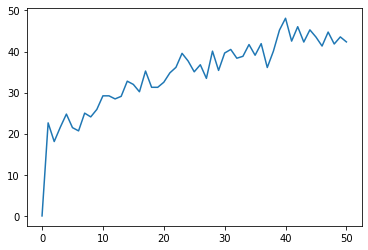

In [11]:
new_entropy_train_err_list = [0]
new_entropy_train_err_list.extend(entropy_train_err_list)
plt.plot(new_entropy_train_err_list)
new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)
plt.legend(['entropy', 'random'])
plt.title("Entropy Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("i.png")
plt.show()

pickle_out = open("entropy_maxmimum.pickle","wb")
pickle.dump(new_entropy_train_err_list, pickle_out)
pickle_out.close()


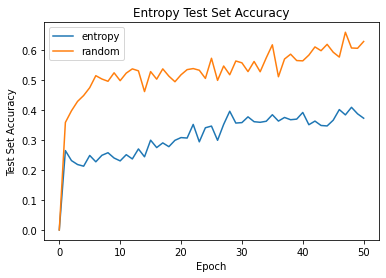

In [68]:
new_entropy_test_err_list = [0]
new_entropy_test_err_list.extend(entropy_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_entropy_test_err_list)
plt.plot(new_rand_test_err_list)
plt.legend(['entropy', 'random'])
plt.title("Entropy Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("j.png")
plt.show()

pickle_out = open("entropy_maximum_testing.pickle","wb")
pickle.dump(new_entropy_test_err_list, pickle_out)
pickle_out.close()

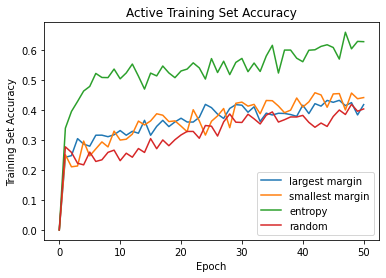

In [69]:
new_active_train_err_list = [0]
new_active_train_err_list.extend(active_train_err_list)
plt.plot(new_active_train_err_list)

new_second_train_err_list = [0]
new_second_train_err_list.extend(second_train_err_list)
plt.plot(new_second_train_err_list)
new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)

new_entropy_train_err_list = [0]
new_entropy_train_err_list.extend(entropy_train_err_list)
plt.plot(new_entropy_train_err_list)
plt.legend(['largest margin', 'smallest margin','entropy', 'random'])
plt.title("Active Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("k.png")
plt.show()


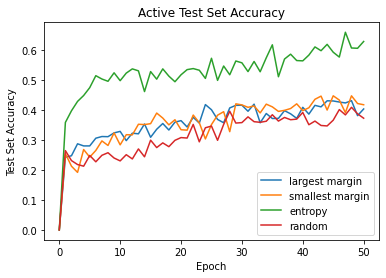

In [81]:
new_active_test_err_list = [0]
new_active_test_err_list.extend(active_test_err_list)

new_second_test_err_list = [0]
new_second_test_err_list.extend(second_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_active_test_err_list)
plt.plot(new_second_test_err_list)
plt.plot(new_rand_test_err_list)

new_entropy_test_err_list = [0]
new_entropy_test_err_list.extend(entropy_test_err_list)
plt.plot(new_entropy_test_err_list)
plt.legend(['largest margin', 'smallest margin','entropy',  'random'])
plt.title("Active Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("l.png")
plt.show()

# Least Confident

In [71]:
# optimal_batch
def uncertainty_metric_lc_selection(model, trainloader):
    batch_evaluation = []
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        batch_differences = []
        for j in range(len(outputs)):
            max_prob = max(outputs[j])
            diff = float(1 - max_prob)
            batch_differences.append(diff)
        batch_mean = np.sum(batch_differences)
        batch_evaluation.append(batch_mean)
    batch_evaluation = np.array(batch_evaluation)
    k = 20
    return list((-batch_evaluation).argsort()[:k])

In [72]:
lc_loss_list = []
lc_acc_list = []
lc_train_err_list = []
lc_test_err_list = []

for trial in range(2):
    lc_model1 = Net3()
    free_params = sum(p.numel() for p in lc_model1.parameters() if p.requires_grad)
    print(free_params)

    trainstep = 125
    # Loss and optimizer

    criterion = nn.NLLLoss() 
    optimizer = optim.SGD(lc_model1.parameters(), lr=0.005, momentum=0.9, weight_decay=8e-4)

    # Training the model

    total_step = len(trainloader)
    print(total_step)
    trial_lc_loss_list = []
    trial_lc_acc_list = []

    trial_lc_train_err_list = []
    trial_lc_test_err_list = []

    num_epochs = 50

    for epoch in range(num_epochs):
        print("epoch: ", epoch)
        total = 0
        correct = 0
        randomly_selected = uncertainty_metric_lc_selection(lc_model1, trainloader)
        for i, (images, labels) in enumerate(trainloader):
            if i not in randomly_selected:
                continue

            images = Variable(images)
            labels = Variable(labels)
            # forward pass
            outputs = lc_model1(images)

            loss = criterion(outputs, labels)
            trial_lc_loss_list.append(loss.item())

            # Backpropagating
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             #accuracy
            total = labels.size(0) + total
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item() + correct
            trial_lc_acc_list.append(correct / total)


            if True:
                w = torch.nn.utils.parameters_to_vector(lc_model1.parameters())
                #print(w)
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
        trial_lc_train_err_list.append(compute_train_acc(lc_model1, trainloader))
        trial_lc_test_err_list.append(compute_test_acc(lc_model1, testloader))
        if (total == correct):
            break 

    lc_loss_list.append(trial_lc_loss_list)
    lc_acc_list.append(trial_lc_acc_list)
    lc_train_err_list.append(trial_lc_train_err_list)
    lc_test_err_list.append(trial_lc_test_err_list)
            
print('Finished Training') 

lc_loss_list = np.array(lc_loss_list)
lc_acc_list = np.array(lc_acc_list)
lc_train_err_list= np.array(lc_train_err_list)
lc_test_err_list=np.array(lc_test_err_list)

lc_loss_list = np.mean(lc_loss_list, axis=0)
lc_acc_list = np.mean(lc_acc_list, axis=0)
lc_train_err_list= np.mean(lc_train_err_list, axis=0)
lc_test_err_list=np.mean(lc_test_err_list, axis=0)
 




120753
157
epoch:  0
Epoch [1/50], Step [1/157], Loss: 4.4262, Accuracy: 9.38%
Epoch [1/50], Step [4/157], Loss: 4.3151, Accuracy: 10.94%
Epoch [1/50], Step [22/157], Loss: 4.2591, Accuracy: 13.54%
Epoch [1/50], Step [25/157], Loss: 4.1855, Accuracy: 15.23%
Epoch [1/50], Step [29/157], Loss: 4.1821, Accuracy: 15.31%
Epoch [1/50], Step [41/157], Loss: 4.1555, Accuracy: 15.62%
Epoch [1/50], Step [42/157], Loss: 4.0407, Accuracy: 16.29%
Epoch [1/50], Step [48/157], Loss: 4.0412, Accuracy: 17.38%
Epoch [1/50], Step [53/157], Loss: 4.1113, Accuracy: 17.88%
Epoch [1/50], Step [61/157], Loss: 4.0277, Accuracy: 18.59%
Epoch [1/50], Step [68/157], Loss: 3.9357, Accuracy: 19.18%
Epoch [1/50], Step [73/157], Loss: 4.0764, Accuracy: 19.66%
Epoch [1/50], Step [82/157], Loss: 3.9436, Accuracy: 20.43%
Epoch [1/50], Step [105/157], Loss: 4.0512, Accuracy: 20.76%
Epoch [1/50], Step [113/157], Loss: 4.0330, Accuracy: 21.04%
Epoch [1/50], Step [118/157], Loss: 3.9410, Accuracy: 21.39%
Epoch [1/50], Step 

In [ ]:
#after training, saving your model 
model_filename = 'model-004.model'
torch.save(lc_model1.state_dict(), model_filename)

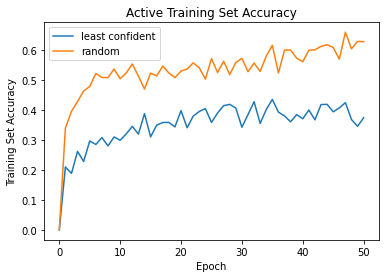

In [76]:
new_lc_train_err_list = [0]
new_lc_train_err_list.extend(lc_train_err_list)
plt.plot(new_lc_train_err_list)
new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)
plt.legend(['least confident', 'random'])
plt.title("Active Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("o.png")
plt.show()

pickle_out = open("lc_maxmimum.pickle","wb")
pickle.dump(new_entropy_train_err_list, pickle_out)
pickle_out.close()

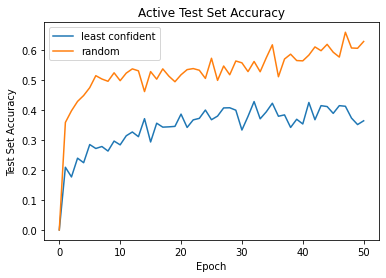

In [78]:
new_lc_test_err_list = [0]
new_lc_test_err_list.extend(lc_test_err_list)
new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_lc_test_err_list)
plt.plot(new_rand_test_err_list)
plt.legend(['least confident', 'random'])
plt.title("Active Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("p.png")
plt.show()

pickle_out = open("lc_maximu.pickle","wb")
pickle.dump(new_entropy_test_err_list, pickle_out)
pickle_out.close()


# Compare All

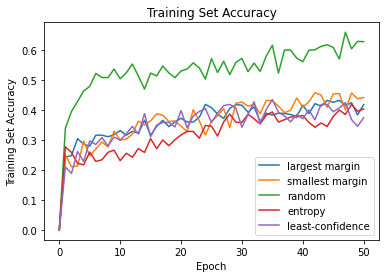

In [82]:
new_active_train_err_list = [0]
new_active_train_err_list.extend(active_train_err_list)
plt.plot(new_active_train_err_list)

new_second_train_err_list = [0]
new_second_train_err_list.extend(second_train_err_list)
plt.plot(new_second_train_err_list)

new_rand_train_err_list = [0]
new_rand_train_err_list.extend(rand_train_err_list)
plt.plot(new_rand_train_err_list)

new_entropy_train_err_list = [0]
new_entropy_train_err_list.extend(entropy_train_err_list)
plt.plot(new_entropy_train_err_list)

new_lc_train_err_list = [0]
new_lc_train_err_list.extend(lc_train_err_list)
plt.plot(new_lc_train_err_list)


plt.legend(['largest margin', 'smallest margin','random', 'entropy', 'least-confidence'])
plt.title("Training Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Set Accuracy")
plt.savefig("p.png")
plt.show()


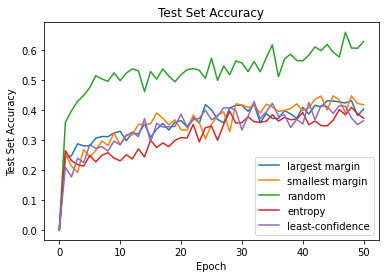

In [83]:
new_active_test_err_list = [0]
new_active_test_err_list.extend(active_test_err_list)

new_second_test_err_list = [0]
new_second_test_err_list.extend(second_test_err_list)

new_rand_test_err_list = [0]
new_rand_test_err_list.extend(rand_test_err_list)

plt.plot(new_active_test_err_list)
plt.plot(new_second_test_err_list)
plt.plot(new_rand_test_err_list)

new_entropy_test_err_list = [0]
new_entropy_test_err_list.extend(entropy_test_err_list)
plt.plot(new_entropy_test_err_list)

new_lc_test_err_list = [0]
new_lc_test_err_list.extend(lc_test_err_list)
plt.plot(new_lc_test_err_list)

plt.legend(['largest margin', 'smallest margin','random', 'entropy', 'least-confidence'])
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Set Accuracy")
plt.savefig("q.png")
plt.show()